In [115]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2
data_home = "../MountainCar"

"../MountainCar"

In [116]:
pwd()

"/home/matthewmcleod/Documents/Masters/curiosity/plotting"

# Plotting

In [117]:
ic = ItemCollection(joinpath(data_home, "data"));

In [118]:
swept_params = diff(ic)

Dict{String,Array} with 5 entries:
  "demon_learner"       => ["TB", "TBAuto"]
  "behaviour_alpha"     => [0.03125, 0.0625]
  "runs"                => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  41, 42, 43, 44, 4…
  "demon_alpha"         => [0.0078125, 0.015625, 0.03125, 0.0625, 0.125]
  "use_external_reward" => Bool[0, 1]

In [164]:
function load_results(ic, logger_key; return_type = "tensor")
    num_results = length(ic)
    results = []
    for itm in ic.items
        data = FileIO.load(joinpath(itm.folder_str, "results.jld2"))["results"]
        push!(results,data[logger_key])
    end
    
    if return_type == "tensor"
        return cat(results..., dims = 3)
    elseif return_type == "array"
        return results
    end
end

load_results (generic function with 1 method)

In [120]:
# After implementing, I think I saw there is a Iterators.product that does this?
function combine(dict_arr, key, vals)
    new_dict_arr = []
    for dict in dict_arr
        for val in vals
            new_dict = deepcopy(Dict(dict))
            new_dict[key] = val
            push!(new_dict_arr, new_dict)
        end
    end
    return new_dict_arr
end

function split_algo(algo_ic, swept_params)
    println(swept_params)
    dicts = [Dict()]
    for k in swept_params
        list_of_params = diff(algo_ic)[k]
        dicts = combine(dicts, k, list_of_params)
    end
    return dicts
end

split_algo (generic function with 1 method)

In [121]:
algo_divisor_keys = ["use_external_reward","demon_learner"]
algo_divisors = split_algo(ic, algo_divisor_keys)

["use_external_reward", "demon_learner"]


4-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "TB","use_external_reward" => false)
 Dict{Any,Any}("demon_learner" => "TBAuto","use_external_reward" => false)
 Dict{Any,Any}("demon_learner" => "TB","use_external_reward" => true)
 Dict{Any,Any}("demon_learner" => "TBAuto","use_external_reward" => true)

In [122]:
sweep_keys = ["behaviour_alpha","demon_alpha"]
sweep_divisors = split_algo(ic,sweep_keys)

["behaviour_alpha", "demon_alpha"]


10-element Array{Any,1}:
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.0078125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.015625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"demon_alpha" => 0.125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.0078125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.015625)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"demon_alpha" => 0.125)

In [123]:
function get_best(ic, sweep_params, metric)
    splits = split_algo(ic,sweep_params)
    errors = ones(length(splits)) * Inf
    for (ind, split) in enumerate(splits)
        res = load_results(search(ic, split), metric)
        error = mean(res)
        errors[ind] = error
    end
    low_err, low_err_ind = findmin(errors)
    
    return search(ic, splits[low_err_ind])
end

get_best (generic function with 1 method)

In [124]:
function get_stats(data;per_gvf=false)
    mean_per_gvf, std_per_gvf = mean(data,dims=3)[:,:,1], std(data,dims=3)[:,:,1]
    
    return a,b = if per_gvf == true
        mean_per_gvf, std_per_gvf
    else
        mean(mean_per_gvf,dims=1)[1,:], mean(std_per_gvf,dims=1)[1,:]
    end
end

get_stats (generic function with 1 method)

In [125]:
algos_ics = [search(ic,algo_divisor) for algo_divisor in algo_divisors]
sweep_params = ["behaviour_alpha","demon_alpha"]
best_per_algo_ics = [get_best(algo_ic,sweep_params, :mc_error) for algo_ic in algos_ics]

["behaviour_alpha", "demon_alpha"]


[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.32204996999374425 0.3220665027858915 0.3220665027858915 0.322062224825436 0.32206216385145775 0.32206216385145775 0.32206188257052604 0.32206188257052604 0.3188664829160114 0.3188664829160114 0.31886574411154345 0.31886574411154345 0.3188668363862835 0.3188668363862835 0.3189563420244083 0.3189679155699421 0.3189679155699421 0.31896814592161987 0.31896814592161987 0.3189955560480206 0.3189955560480206 0.3190140898889815 0.3190362773708743 0.31903743484251784 0.3190439074580461 0.3190439074580461 0.3190783340800199 0.3190783340800199 0.31813806959606267 0.31813806959606267 0.3181370639068761 0.3181370639068761 0.31815068123831314 0.31815068123831314 0.31814917815202387 0.3181499567326421 0.3181499567326421 0.3181518252648632 0.3181518252648632 0.31817451269540387 0.31817451269540387 0.31816862837367693 0.318174624159506 0.318174624159506 0.3181687386775687 0.3181687386775687 0.3181651413855755 0.3181651413855755 0.31704463136828837 0.31704463136828837 0.3170375123252286 0.31703751232

 0.1181725225126418 0.11867660992349174 0.11867660992349174 0.11924758320436624 0.11923691832283452 0.11923691832283452 0.11921628143285078 0.11921628143285078 0.12110543103940506 0.12110543103940506 0.12145139052092352 0.12145139052092352 0.12210199362909899 0.12210199362909899 0.1233890827293535 0.1233890827293535 0.12328954272952758 0.12321153256436018 0.12321153256436018 0.12314599538445885 0.12314599538445885 0.1230107740866335 0.1230107740866335 0.12268140020792245 0.12268140020792245 0.12183043001311422 0.12183043001311422 0.12000422360699878 0.12000422360699878 0.1191154520848198 0.11909435279532836 0.11909435279532836 0.11874933673837668 0.11874933673837668 0.12017332362630581 0.12013714638768783 0.12013714638768783 0.1175141025191492 0.1175141025191492 0.11755512722832273 0.11755512722832273 0.11712832439312354 0.11712832439312354 0.11461787848366463 0.11461787848366463 0.11461787848366463 0.11359219121082048 0.11359219121082048 0.11220501098614027 0.11220803652242806 0.11220

 0.12573709392800728 0.12570735869410013 0.12570735869410013 0.12659693236659073 0.1266365393157542 0.12641261195880824 0.12670672003036418 0.12670672003036418 0.12650635416144676 0.12650635416144676 0.12651781388777905 0.12651781388777905 0.12575207241741992 0.12618594321335927 0.1260874691214227 0.1276554358444116 0.1276554358444116 0.12755069912136002 0.12755069912136002 0.12727266907153426 0.12727266907153426 0.12727266907153426 0.12761243187805013 0.12590671653934427 0.12577534273904672 0.12569754470173858 0.12569754470173858 0.12746438189442597 0.12746438189442597 0.12795441183218262 0.12795441183218262 0.1272641473217132 0.12729258021000212 0.12801890280564196 0.12838193929174926 0.12827309433150869 0.12910893884010255 0.12910893884010255 0.12923595889953282 0.12923595889953282 0.12992485273092347 0.129907872333765 0.129907872333765 0.1280776196024343 0.1280776196024343 0.1280482761114451 0.1280482761114451 0.1289853521271873 0.1289853521271873 0.1291003616396374 0.1293123293783

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.3264880783389399 0.326488

 0.30112107777271946 0.30112107777271946 0.3010556480764727 0.3010556480764727 0.29773764419111504 0.29773764419111504 0.296303488808536 0.296303488808536 0.296303488808536 0.296303488808536 0.2962808514663382 0.2962808514663382 0.2929919094082808 0.29297774286662004 0.2888420658029996 0.2888420658029996 0.2888420658029996 0.2888420658029996 0.2884202539528862 0.2884202539528862 0.2884332830825928 0.2883729422067195 0.287696545104608 0.2864759738761845 0.2864775630403085 0.2853471711247116 0.2853471711247116 0.28519077689167244 0.28519077689167244 0.28519077689167244 0.28519077689167244 0.28380692295005333 0.28380692295005333 0.283786577055989 0.283786577055989 0.283786577055989 0.283786577055989 0.283786577055989 0.2827253979003367 0.2827253979003367 0.28224280421497405 0.28224280421497405 0.281713113707863 0.281713113707863 0.2798951394186714 0.2798951394186714 0.2778770267578363 0.2778770267578363 0.2764543961801136 0.2764543961801136 0.2764368284740087 0.2764368284740087 0.27643682

 0.12546628920910174 0.12546628920910174 0.12546628920910174 0.12546628920910174 0.12546628920910174 0.12546628920910174 0.12546628920910174 0.12546594162403735 0.12546594162403735 0.12546594162403735 0.12546594162403735 0.1255020050890425 0.1255020050890425 0.1255020050890425 0.1255020050890425 0.1255937087779017 0.1255937087779017 0.1255937087779017 0.1255937087779017 0.1255937087779017 0.1255937087779017 0.12558270703594746 0.12558270703594746 0.12558312102731273 0.12558312102731273 0.12557966312137087 0.12557966312137087 0.12557966312137087 0.12557966312137087 0.1255796631656102 0.1255796631656102 0.1255796631656102 0.1255796631656102 0.12557305909512603 0.12557305909512603 0.12557305909512603 0.12557305909512603 0.12557305909512603 0.12557305874736463 0.12557305874736463 0.12557305874736463 0.12557305874736463 0.12557305874135 0.12557305625783655 0.12557296239834714 0.12557296239834714 0.12557296240855184 0.12557296250309358 0.12557296250309358 0.12557296250309358 0.12557296250309

 0.1361403479302548 0.1361403479302548 0.1361403479302548 0.1365357169620828 0.1365357169620828 0.1365357169620828 0.1365357169620828 0.13650111532894596 0.13650111532894596 0.13709047181443768 0.13709047181443768 0.1378125991720556 0.1378125991720556 0.13781259703059076 0.13781258769410132 0.13781258769410132 0.13792535020774557 0.13796107503501445 0.13796107503501445 0.13796107503501445 0.13787334902840295 0.1408199500296592 0.1408199500296592 0.14076083930532302 0.14076083930532302 0.1407010246369426 0.1407010246369426 0.1407010246369426 0.1407010246369426 0.140608536816831 0.140608536816831 0.13916940893410348 0.1391391616281188 0.13964096569430226 0.13964096569430226 0.14122843214961503 0.14122843214961503 0.14002162272330185 0.14063502251763121 0.14063502251763121 0.14044335247439899 0.14044335247439899 0.14054257454160252 0.14054257454160252 0.14020313617514513 0.14020313617514513 0.14003341167137504 0.14003341167137504 0.1380765646865106 0.1380765646865106 0.13715670094109952 0

 0.12349565094299353 0.12338933456982641 0.12338933456982641 0.12353243793217362 0.12353243793217362 0.12386443141130356 0.12386443141130356 0.12386443141130356 0.12386443141130356 0.1236739160476696 0.1236739160476696 0.1236739160476696 0.1236739160476696 0.12362475264792266 0.1236052875210356 0.1236052875210356 0.1236052875210356 0.1236052875210356 0.1236052875210356 0.1236052875210356 0.1236052875210356 0.12356878489532433 0.12356600716716183 0.12356600716716183 0.12356600716716183 0.12356600716716183 0.12358850683248308 0.12358850683248308 0.12329596332658023 0.12329596332658023 0.12335325709801447 0.12335325709801447 0.12316537215628964 0.12316537215628964 0.12316747703658253 0.12316747717383833 0.12316745697852108 0.12315616323304424 0.12315616323304424 0.12322406502960108 0.12322406502960108 0.12309705233293855 0.12309705233293855 0.12309705233293855 0.12309705233293855 0.1231032951450564 0.1231032951450564 0.1231032951450564 0.1231032951450564 0.12310729218625811 0.123051378539

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.3157274299205561 0.3157274299205561 0.31559460683288415 0.3155917130915078 0.3155917130915078 0.31559336676690725 0.31527174227491256 0.3152717393899373 0.3152000439430144 0.31520041169176655 0.3151462720414161 0.3151462720414161 0.3151540494733223 0.3151540494733223 0.31515554494742826 0.31515534245468174 0.31485688281266083 0.31485688281266083 0.31431531081138314 0.31431531081138314 0.31434306023225317 0.31401124732641444 0.31399691444945593 0.3139951586637523 0.3139951586637523 0.31400878295527734 0.31400878295527734 0.31397219990371217 0.31397219990371217 0.31397035079644836 0.31397035079644836 0.3139655116772486 0.3139655116772486 0.3138872249180286 0.3138261741868512 0.31382212038776286 0.31373823422128516 0.31372011366640445 0.3134337922444225 0.3134225260092949 0.31341614238467946 0.31341614238467946 0.31342260327811805 0.3132869334346708 0.3132869334346708 0.31325635782475447 0.31325635782475447 0.3132528447730454 0.3132528447730454 0.31326023913300227 0.31326023913300227 0

 0.1150803666301009 0.11539557259321835 0.11539557259321835 0.11727718067899119 0.11750733185786105 0.11750733185786105 0.11750733185786105 0.11750733185786105 0.11810909588388055 0.11810909588388055 0.11810963225908858 0.11810963225908858 0.11801526960404951 0.11801526960404951 0.11789402742295245 0.11859749727949946 0.11859749727949946 0.11936525510219653 0.11936525510219653 0.11936525510219653 0.11936525510219653 0.11936525510219653 0.11936525510219648 0.11936525510219648 0.11936525510219648 0.11936525513256653 0.11936525509225483 0.11936525509340719 0.11936525508038759 0.1193652550728114 0.1193652550637081 0.11936525512350787 0.1193652550882888 0.11936525508757727 0.11936525509506525 0.11936525504346061 0.11936525506672999 0.1193652550687962 0.11936525506979895 0.11936481942459187 0.11936481942459187 0.1194184836503936 0.11977524554381778 0.11977524554381778 0.11977524554381778 0.11977524554381778 0.11918048256766171 0.11918048256766171 0.11933298370205568 0.11933298370205568 0.119

 0.16893508251396538 0.16823738958494974 0.16826466678975333 0.16483344602621006 0.16482121126483956 0.16487198401715683 0.16487198401715683 0.1649427108075603 0.1649427108075603 0.1649427108075603 0.1651609219586021 0.16516022300797467 0.16499146098884207 0.16499328758604462 0.16417807996283845 0.16522392777342795 0.16522392777342795 0.16513739531030822 0.1648753587387368 0.16527014200863813 0.16527014200863813 0.17040822509141537 0.17040822509141537 0.17017447422841545 0.17001427906068414 0.17001427906068414 0.169965170891786 0.169965170891786 0.16978518576976456 0.16765282776846188 0.16765282776846188 0.16765282776846188 0.16873370622526307 0.16873370622526307 0.16873372782273047 0.1685909619248791 0.16914860527647246 0.16914860527647246 0.16914860527647246 0.1691715421324149 0.1691715421324149 0.16838032822344143 0.168244697233459 0.168244697233459 0.16382307569903465 0.16459562859654558 0.16459562859654558 0.16686948674630767 0.16686948674630767 0.16647052206288693 0.1661421987318

 0.12904174457868622 0.12855314469786286 0.12861333030329775 0.12865733239901414 0.1260040632425217 0.12602859935337432 0.12475985708340728 0.12856500271270055 0.12856500271270055 0.12899377006149185 0.1270854787186716 0.1270854787186716 0.1270765011229556 0.1286129432943997 0.1300827068368122 0.1300827068368122 0.129462456478699 0.129462456478699 0.12901820651331086 0.12901820651331086 0.12901820651331086 0.12575955933363878 0.12470347838266806 0.12468145404815496 0.12444705646548294 0.124482280050649 0.124482280050649 0.12430063702213348 0.12463323816498444 0.12463323816498444 0.12383766804917043 0.12383766804917043 0.12267754334271982 0.12244813698918432 0.12244813698918432 0.12244813698918432 0.12194819984643773 0.12194819984643773 0.12228864721276421 0.12228864721276421 0.12261770290020708 0.12261770290020708 0.12497446020913403 0.12497446020913403 0.12477400422858642 0.12477400422858642 0.12608671140248667 0.12620817390436456 0.12575035636466367 0.12604357536816083 0.124757932471

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880785400948 0.326488078541257 0.32648807854251166 0.32648807854388673 0.32648807854422657 0.32648807854619366 0.32648807854619366 0.3264880785488169 0.3264880785488169 0.3264880785497023 0.3264880785497023 0.32648807855704476 0.3264880785572112 0.3264880785613917 0.3264880785625962 0.3264880785690037 0.32648807857227047 0.32648807743755187 0.3264880773292404 0.32648802312522535 0.32648800575184034 0.3264879578781386 0.3264879578781386 0.3264879344121001 0.3264879344121001 0.32648790339293443 0.32648789553424956 0.3264878688514397 0.32648780523152

 0.15732851883670865 0.15704910823584226 0.15704910823584226 0.15764233526310314 0.15764233526310314 0.15781924382377516 0.15781924382377516 0.15846165943805926 0.15846165943805926 0.15849729205207688 0.15849729205207688 0.1584941991026032 0.1584941991026032 0.1584941991026032 0.15863060445186516 0.15863060445186516 0.1586358805591175 0.1586358805591175 0.15858439943360467 0.15840159590543057 0.15838506253188367 0.1585525017738284 0.1585525017738284 0.1585525017738284 0.1585525017738284 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15858430828022718 0.15863984825168992 0.15863984825168992 0.15863984825168992 0.15863984825168992 0.15863984825168992 0.15885033594711262 0.1587942640341839 0.1587942640341839 0.15871612855893777 0.15871612855893777 0.15871612855893777 0.15903522157712405 0.15903522157712405 0.15903522157712405 0.15903522157712405 0.15903522157712405 0.15903522157712405 0.15896826

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.1857011060352317 0.1857011060352317 0.1857011060352317 0.1857011060352317 0.1857011060352317 0.1857011060352317 0.18524304466570304 0.18524304466570304 0.18532583355576918 0.1863637243200059 0.1871788309096331 0.1870300246867825 0.1870300246867825 0.1869030668531181 0.18689237102249506 0.18689237102249506 0.18628974587635763 0.18628974587635763 0.18667673594486003 0.186739622216216 0.186739622216216 0.18650491999969204 0.18650491999969204 0.18662859992159628 0.18662859992159628 0.18643729591403385 0.18643729591403385 0.18728041055943262 0.18728041055943262 0.18683249820980147 0.18683249820980147 0.18775141548324115 0.18734711128017512 0.18736032058116073 0.1873618137042906 0.1873350479162811 0.1873350479162811 0.18688135325599003 0.18688135325599003 0.18682684093231905 0.18682684093231905 0.18610623607506535 0.18610623607506535 0.1853342919607404 0.1853342919607404 0.185207985201806 0.18505835242502455 0.18505886627227486 0.18556351178850722 0.1852248336812326 0.18477256959930038 0.

 0.16031043055590766 0.16046433260550164 0.16046433260550164 0.16046433260550164 0.16046433260550164 0.16046433260550164 0.16046433260550164 0.16053718501062775 0.16053718501062775 0.16072292217078643 0.16087712539844468 0.16087712539844468; 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908802536

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.16785822154326563 0.16785822154326563 0.1678825605736673 0.1678825605736673 0.16774220142817314 0.16774220142817314 0.16807098441282675 0.16807098441282675 0.1683147272211259 0.16930273884576544 0.16930273884576544 0.16960408047489875 0.16960408047489875 0.17047162422431644 0.17047162422431644 0.17046708579202466 0.17116046385573347 0.17116046385573347 0.1716943633607388 0.1716943633607388 0.17155872442294573 0.17155872442294573 0.1716543372517338 0.1716543372517338 0.17250074192904122 0.17250074192904122 0.17244492219583724 0.17244492219583724 0.17316186118931345 0.17316186118931345 0.17319038710242726 0.17319038710242726 0.17320439868692017 0.17390499700995432 0.1747617126914388 0.1746329128920025 0.1754016875434679 0.1754016875434679 0.1754016875434679 0.1754016875434679 0.17546405761337563 0.17546405761337563 0.17623496796759708 0.17623496796759708 0.17623496796759708 0.1762080858327124 0.1762080858327124 0.1762110408860109 0.1762110408860109 0.1765943238485658 0.176594323848565

 0.1815467303999763 0.18212548014367635 0.1828191545234173 0.18316554138827632 0.18351396388995572 0.18351396388995572 0.18343506278938737 0.18343506278938737 0.1840376189623214 0.1840376189623214 0.18420385264745334 0.18420385264745334 0.1844809559186764 0.1844809559186764 0.18469283805674525 0.18469283805674525 0.18471431293676563 0.18490931121943938 0.18490931121943938 0.18490931121943938 0.18490931121943938 0.18515685113134958 0.18515685113134958 0.18515685113134958 0.18515685113134958 0.18512730476733488 0.18512730476733488 0.18512730476733488 0.18512730476733488 0.18512730476733488 0.18512730476733488 0.18512730476733488 0.18517556176261213 0.18517556176261213 0.18505404094771502 0.18505404094771502 0.18513980751519976 0.18513980751519976 0.18448366516938278 0.18443603043301585 0.18443603043301585 0.18443603043301585 0.18443603043301585 0.18443603043301585 0.18443603043301585 0.18443603043301585 0.18471582041290144 0.18471582041290144 0.1843457565052812 0.1843457565052812 0.18334

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.2170167854236894 0.2170167854236894 0.21578400987757973 0.21578400987757973 0.2159524904754198 0.2159524904754198 0.2153012861100522 0.2153012861100522 0.2138644983805198 0.21356421066046186 0.21363928562630202 0.2130918264587523 0.2133123986398337 0.21337062358121894 0.2130578830818594 0.21220884933536774 0.21148630738820265 0.21104408254891674 0.21109384694024008 0.2107742004690749 0.21085496132265566 0.21055287009307322 0.21080799418930507 0.2106726597143442 0.21054773723581438 0.21038123256945998 0.21038123256945998 0.21015938225295025 0.21015938225295025 0.21089673252084928 0.21089673252084928 0.21092058618038131 0.21092058618038131 0.21003742339860287 0.21003742339860287 0.2109298564923544 0.2109298564923544 0.21031688870650853 0.21023165765995983 0.2101696831514548 0.20982522995602487 0.2097785530808535 0.2093820055703844 0.20909395585270174 0.20933413705810672 0.20929528479053894 0.2103191634317031 0.2103191634317031 0.21031926782558422 0.21010910985765796 0.2101091098576579

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.3258949246020472 0.3258949246020472 0.3258372093747329 0.3258372093747329 0.3258373081493582 0.3258373081493582 0.32582675544697026 0.32582675544697026 0.32580681451071797 0.32580681451071797 0.3257946521311488 0.3257854045587733 0.32580421271302684 0.32580091416140106 0.32580029887073403 0.32580029887073403 0.32580029887073403 0.32580029887073403 0.32580029887073403 0.32580029887073403 0.32572053025726005 0.32572053025726005 0.3256963083805069 0.3256644112949488 0.32566476944259193 0.3256400318013609 0.3256204206219494 0.3254399827396755 0.32543542840237644 0.3253661388347166 0.3253661388347166 0.325346548035978 0.325346548035978 0.32534650586461145 0.32534650586461145 0.32525798337919704 0.32525798337919704 0.325169955609649 0.325169955609649 0.32517034580743903 0.32517034580743903 0.32515729689108896 0.32515729689108896 0.325140886498815 0.325140886498815 0.32513053945078346 0.32513053945078346 0.32510299540773 0.32510299540773 0.32509250534099704 0.32509250534099704 0.3250538590

 0.12611452572945253 0.12618527239794916 0.12618527239794916 0.12618527239794916 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12563741624969596 0.12562399221940887 0.12562399221940887 0.12562305325822756 0.12562305325822756

 0.12183140131401636 0.12183140131401636 0.12160822401182182 0.12160822401182182 0.12162449107853485 0.12162449107853485 0.1216817813400851 0.1216817813400851 0.12187160907541272 0.12187160907541272 0.1217817886655534 0.1217817886655534 0.12219250724906729 0.12219250724906729 0.12278532840689461 0.12278532840689461 0.12278885058742636 0.12278885058742636 0.12296305245902017 0.12296305245902017 0.1227551692279496 0.1227551692279496 0.1229033992969115 0.1229033992969115 0.122803014728925 0.122803014728925 0.122803014728925 0.122803014728925 0.12199772957874444 0.12199772957874444 0.1209332810006602 0.1209332810006602 0.11988579707150501 0.11988579707150501 0.11897714364196635 0.11897714364196635 0.11835818916636644 0.11841957569617217 0.11836895468942238 0.11836895468942238 0.11763848855479092 0.11763848855479092 0.11777289205681422 0.11702433756486563 0.11702433756486563 0.11683625752295472 0.11683625752295472 0.11683625752295472 0.11683625752295472 0.11655987876549748 0.116559878765497

 0.12139723629786996 0.1213385577495606 0.1213385577495606 0.12153009600917676 0.12153009600917676 0.12153047843731019 0.12153047843731019 0.12162158326078472 0.12162158326078472 0.12162158326078472 0.12165106927814584 0.12165417591425323 0.12167424221789609 0.12167424221789609 0.12203372668692979 0.12203372668692979 0.12173288171950279 0.12172772453541056 0.12172772453541056 0.12161836845968332 0.12161836845968332 0.12221272083113562 0.12221272083113562 0.12242051723951676 0.12242051723951676 0.12268027241696432 0.12268027241696432 0.12256471450230066 0.12256471450230066 0.12262037896000644 0.12262037896000644 0.12265311102003355 0.12265311102003355 0.12265311102003355 0.12265311102003355 0.12268225834128907 0.12268225834128907 0.12269828114566028 0.12269828114566028 0.12269828114566028 0.12269828114566028 0.12266416975560929 0.12266416975560929 0.12264530571398381 0.12264530571398381 0.12264530571398381 0.12264530571398381 0.12248997044492721 0.12248997044492721 0.1228083281761621 0.

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.326488068584849 0.32648806499286054 0.32648804950955884 0.32648804950955884 0.32648804913953955 0.32648804913953955 0.32648804879655535 0.32648804879655535 0.3264879799671271 0.3264879798164506 0.3264879798164506 0.3264879798164506 0.326487813034816 0.3264878132003842 0.3264878132003842 0.3264878132003842 0.3264878132003842 0.3264878132003842 0.3264878132

 0.2177390431290483 0.21775918978903452 0.21771820965833524 0.21771820965833524 0.21771820965833524 0.21771820965833524 0.2179035746643712 0.2179035746643712 0.2179035746643712 0.2179035746643712 0.21848308286470008 0.21850369008469264 0.21894748361666685 0.21893454978568502 0.2191548820730224 0.2191548820730224 0.2191548820730224 0.22026107960255806 0.22026107960255806 0.22136556123427162 0.22136556123427162 0.22145776277947413 0.22145776277947413 0.22215346769134064 0.22215346769134064 0.22280418189764983 0.22514838673769577 0.22483814898510787 0.22529142487207385 0.22532495460436963 0.22632315122548335 0.22632315122548335 0.22676570633904916 0.22676570633904916 0.22698199617450562 0.22690594699746022 0.22690594699746022 0.2272111762778771 0.22791386431061184 0.22845537326095097 0.22925299782753403 0.22926583058300115 0.23009833055994725 0.23009833055994725 0.23026549471102734 0.23026549471102734 0.23048360069980892 0.23070016039256758 0.23070016039256758 0.2307168974039693 0.2307168

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.2563801794983456 0.2554624299197117 0.2554624299197117 0.2554624299197117 0.25564332426772496 0.2557592845885416 0.2557592845885416 0.25507587061642023 0.25507587061642023 0.25478119597339455 0.25478119597339455 0.25478119597339455 0.25478119597339455 0.25459123863283656 0.25459123863283656 0.2545750937890553 0.2545750937890553 0.2546897510250311 0.2546897510250311 0.254088976650277 0.254088976650277 0.253686265835432 0.253686265835432 0.2523284747838744 0.2520354950063985 0.2520354950063985 0.2520354950063985 0.25208421199786096 0.25208421199786096 0.24910961829930098 0.24910961829930098 0.24900307559676038 0.24900307559676038 0.24900307559676038 0.24900307559676038 0.24827354282918976 0.24827354282918976 0.2479168842626766 0.2479168842626766 0.24696625470882125 0.24696625470882125 0.24685323734516598 0.24685323734516598 0.24685323734516598 0.24685323734516598 0.2464301971341368 0.2464301971341368 0.24658875299193883 0.24658875299193883 0.2465206529082759 0.2465206529082759 0.24652

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366]


[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.14198661854926653 0.14198661854926653 0.14189738846854458 0.14189738846854458 0.14176183947665016 0.14176183947665016 0.1417312518835091 0.1417312518835091 0.1417312518835091 0.1415948105115234 0.1415948105115234 0.14004614046875263 0.14004614046875263 0.14006723497744397 0.14006723497744397 0.14006723497744397 0.14010407405241998 0.14007834821293952 0.14007834821293952 0.14007834821293952 0.14003473952028167 0.14003473952028167 0.13995163625955306 0.13995163625955306 0.13988693227614538 0.13988693227614538 0.1397201451946858 0.1397201451946858 0.13969268499527718 0.13969268499527718 0.13969247732978549 0.13969247732978549 0.13969247732978549 0.13967785040402375 0.13967785040402375 0.13967785040402375 0.13967785040402375 0.13958827996646886 0.13958827996646886 0.13954598655235576 0.13950173252912695 0.1394366413520432 0.13932702179099887 0.13932702179099887 0.13927165930162555 0.13927165930162555 0.13923488481807916 0.13923488481807916 0.138931053951995 0.138931053951995 0.138839532

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

Excessive output truncated after 524303 bytes.

 0.3263462945954987 0.3263462945954987 0.3263316374822915 0.3263317192874922 0.32632453408975515 0.32631018464485584 0.326303300648894 0.326274669602234 0.3262401504688459 0.32624015046186633 0.32624015046186633 0.32624015046186633 0.3262392434426041 0.3262380344542127 0.32622455085395463 0.32622455085395463 0.326224229206945 0.3262400329513164 0.326256705118335 0.32628584674464683 0.32627573920509206 0.32629009349565313 0.326283586477644 0.3263555939916708 0.3263705621927558 0.32638380776756704 0.32637999193243483 0.3263642783601358 0.32642536914323195 0.326406644199038 0.32640051138222853 0.32639450072127013 0.3263825843235067 0.32637670692678483 0.326353591893537 0.32634148621151227 0.3264413720891601 0.32650083993080253 0.32647730060792435 0.3264716008313011 0.3264548573599642 0.3264493799612621 0.3264439575826589 0.3264385814963103 0.3264332389249447 0.32643328831574836 0.32641756104137726 0.3264022181408611 0.32638237469931125 0.32637327872185856 0.32636375509805327 0.32635902868

4-element Array{ItemCollection,1}:
 ItemCollection(Reproduce.Item[Reproduce.Item("../MountainCar/data/RP_0_0x10ae09bcf792fc8e", Dict{String,Any}("steps" => 60000,"demon_alpha" => 0.03125,"use_external_reward" => false,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "behaviour_alpha", "use_external_reward"],"numtilings" => 8,"demon_learner" => "TB","behaviour_alpha" => 0.0625,"numtiles" => 8,"exploring_starts" => true…), ["demon_learner", "logger_keys", "behaviour_gamma", "steps", "behaviour_learner", "behaviour_alpha", "numtiles", "behaviour_trace", "save_dir", "demon_alpha", "use_external_reward", "demon_alpha_init", "exploring_starts", "lambda", "save_keys", "runs", "seed", "numtilings", "intrinsic_reward", "demon_policy_type"]), Reproduce.Item("../MountainCar/data/RP_0_0x12e9a41a7f204092", Dict{String,Any}("steps" => 60000,"demon_alpha" => 0.03125,"use_external_reward" => false,"_GIT_INFO" => "0","save_keys" => ["demon_learner", "runs", "demon_alpha", "beh

In [126]:
function print_params(ic, algo_params, sweep_params)
end

load_results(best_per_algo_ics[4],:episode_length)

[1000, 1000, 1000, 504, 177, 394, 254, 244, 91, 95, 97, 96, 102, 102, 95, 101, 94, 168, 91, 190, 172, 210, 212, 109, 101, 101, 88, 82, 85, 107, 123, 80, 100, 160, 81, 172, 86, 86, 187, 84, 172, 104, 88, 138, 108, 108, 262, 103, 257, 176, 110, 238, 171, 162, 84, 155, 106, 277, 245, 102, 174, 85, 103, 82, 88, 179, 105, 89, 93, 85, 84, 86, 83, 106, 164, 85, 94, 83, 90, 84, 94, 112, 93, 90, 140, 93, 82, 85, 102, 88, 127, 94, 96, 93, 209, 130, 89, 90, 166, 103, 94, 196, 165, 126, 93, 100, 89, 98, 112, 104, 123, 88, 99, 86, 128, 112, 120, 89, 91, 188, 104, 105, 120, 106, 86, 185, 103, 90, 85, 175, 94, 87, 105, 120, 105, 108, 107, 92, 100, 88, 81, 96, 96, 101, 106, 212, 111, 162, 101, 87, 88, 159, 96, 91, 220, 271, 243, 206, 95, 87, 95, 91, 258, 87, 92, 190, 106, 117, 161, 98, 403, 105, 221, 92, 163, 203, 88, 192, 82, 154, 173, 87, 85, 97, 82, 151, 90, 87, 198, 101, 87, 200, 104, 84, 160, 101, 188, 109, 101, 97, 141, 87, 91, 164, 94, 91, 98, 99, 99, 83, 89, 96, 91, 98, 124, 94, 98, 97, 83, 94

[285, 1000, 199, 1000, 124, 926, 437, 608, 393, 339, 89, 94, 92, 307, 85, 91, 171, 84, 262, 93, 95, 90, 101, 95, 279, 168, 92, 225, 166, 87, 97, 83, 88, 103, 162, 93, 88, 92, 87, 88, 87, 163, 83, 168, 85, 92, 94, 90, 98, 85, 83, 99, 96, 95, 255, 95, 139, 92, 84, 90, 159, 84, 107, 158, 100, 88, 95, 102, 93, 91, 185, 91, 89, 81, 178, 203, 82, 100, 98, 101, 265, 84, 93, 103, 183, 87, 101, 82, 91, 83, 156, 161, 178, 139, 178, 97, 201, 87, 121, 83, 100, 102, 160, 92, 105, 85, 100, 149, 100, 179, 101, 93, 274, 92, 127, 87, 194, 86, 92, 105, 96, 91, 89, 150, 86, 154, 86, 95, 85, 174, 84, 117, 98, 127, 122, 100, 101, 125, 106, 107, 101, 125, 98, 93, 88, 116, 88, 216, 103, 107, 155, 87, 79, 94, 158, 84, 158, 105, 109, 126, 170, 201, 88, 118, 148, 100, 108, 95, 103, 149, 118, 97, 159, 90, 224, 165, 221, 266, 101, 95, 105, 84, 139, 89, 86, 221, 129, 109, 94, 90, 105, 87, 104, 90, 100, 141, 154, 86, 87, 105, 111, 170, 103, 107, 109, 97, 164, 133, 163, 89, 110, 109, 95, 106, 208, 160, 86, 92, 193, 

[1000, 1000, 938, 644, 448, 414, 253, 94, 90, 93, 103, 254, 402, 332, 182, 167, 339, 105, 97, 155, 154, 216, 105, 86, 96, 156, 89, 211, 86, 105, 106, 96, 90, 85, 83, 89, 85, 101, 83, 85, 99, 156, 95, 100, 83, 109, 91, 104, 101, 93, 87, 86, 97, 101, 83, 93, 84, 96, 98, 134, 94, 87, 85, 85, 101, 92, 172, 100, 82, 103, 94, 96, 113, 100, 100, 94, 82, 85, 96, 85, 119, 205, 99, 84, 87, 84, 98, 107, 96, 183, 152, 195, 96, 95, 91, 94, 177, 98, 202, 88, 118, 320, 160, 251, 86, 101, 116, 189, 368, 93, 174, 173, 176, 90, 337, 107, 262, 90, 89, 106, 101, 81, 102, 103, 191, 192, 86, 107, 89, 86, 165, 90, 92, 87, 154, 93, 105, 91, 102, 93, 104, 106, 92, 96, 92, 104, 107, 147, 100, 88, 167, 105, 98, 85, 90, 90, 94, 104, 87, 86, 89, 84, 98, 92, 88, 96, 87, 91, 86, 86, 151, 91, 90, 152, 98, 88, 86, 119, 101, 114, 90, 88, 91, 100, 90, 119, 91, 94, 118, 91, 83, 90, 90, 107, 93, 113, 104, 91, 89, 84, 84, 191, 89, 107, 85, 225, 87, 85, 88, 90, 125, 105, 108, 90, 130, 99, 141, 89, 101, 162, 274, 108, 134, 1

[1000, 1000, 418, 676, 505, 341, 185, 107, 750, 95, 478, 91, 107, 89, 161, 95, 98, 93, 98, 317, 89, 89, 163, 247, 92, 87, 83, 83, 95, 195, 96, 99, 92, 95, 92, 94, 105, 127, 98, 193, 113, 164, 91, 211, 92, 98, 182, 83, 93, 200, 157, 164, 102, 98, 194, 103, 89, 168, 235, 100, 97, 89, 102, 101, 96, 100, 86, 303, 192, 97, 98, 102, 109, 166, 101, 104, 91, 112, 87, 98, 93, 180, 195, 103, 112, 105, 105, 179, 100, 93, 89, 167, 198, 157, 101, 95, 88, 189, 103, 88, 100, 162, 93, 211, 109, 124, 86, 131, 90, 102, 91, 157, 165, 105, 179, 148, 113, 215, 87, 132, 132, 159, 109, 91, 87, 110, 107, 98, 93, 89, 95, 155, 110, 90, 99, 93, 93, 95, 193, 134, 95, 91, 87, 97, 93, 106, 87, 111, 95, 120, 107, 93, 208, 105, 110, 90, 93, 112, 154, 106, 86, 118, 105, 160, 106, 95, 90, 113, 106, 86, 107, 109, 89, 97, 110, 98, 89, 94, 99, 96, 85, 90, 96, 244, 92, 172, 126, 121, 103, 111, 113, 94, 93, 198, 159, 249, 295, 219, 101, 252, 197, 243, 125, 258, 107, 200, 96, 195, 95, 195, 211, 201, 93, 94, 88, 102, 166, 114

[1000, 1000, 648, 228, 582, 100, 501, 244, 100, 97, 228, 97, 323, 178, 100, 98, 160, 276, 360, 231, 246, 165, 97, 93, 103, 173, 107, 210, 105, 87, 101, 165, 89, 90, 92, 82, 98, 98, 93, 88, 104, 97, 192, 90, 180, 86, 85, 82, 93, 170, 110, 170, 85, 104, 255, 207, 205, 92, 98, 187, 90, 103, 94, 93, 100, 162, 196, 87, 105, 89, 85, 165, 85, 91, 100, 87, 223, 85, 97, 87, 94, 189, 81, 192, 276, 95, 94, 152, 157, 169, 98, 88, 93, 170, 91, 88, 84, 111, 132, 230, 99, 174, 91, 198, 93, 122, 93, 94, 240, 96, 92, 193, 92, 83, 92, 91, 93, 87, 85, 88, 174, 114, 94, 91, 106, 160, 121, 167, 90, 94, 85, 211, 102, 86, 90, 89, 102, 104, 128, 92, 189, 101, 96, 100, 248, 156, 92, 108, 96, 91, 107, 218, 93, 86, 101, 93, 117, 91, 84, 158, 83, 100, 90, 103, 85, 91, 105, 87, 108, 120, 107, 84, 88, 166, 104, 108, 150, 93, 157, 105, 201, 96, 268, 87, 93, 106, 200, 272, 94, 110, 92, 91, 110, 106, 178, 93, 106, 97, 90, 97, 89, 153, 94, 90, 87, 168, 293, 299, 275, 102, 92, 104, 94, 112, 91, 92, 94, 281, 221, 91, 94,

[1000, 1000, 1000, 110, 728, 172, 277, 557, 472, 223, 84, 92, 213, 105, 86, 89, 162, 84, 231, 89, 94, 163, 163, 102, 91, 92, 151, 95, 85, 83, 95, 89, 98, 159, 155, 94, 163, 90, 151, 82, 90, 89, 101, 199, 102, 116, 152, 114, 162, 83, 171, 89, 85, 162, 87, 109, 152, 99, 103, 95, 175, 101, 187, 84, 87, 96, 89, 94, 138, 161, 95, 89, 83, 86, 83, 121, 108, 89, 100, 163, 161, 107, 84, 88, 101, 162, 84, 96, 159, 84, 173, 90, 117, 109, 89, 190, 102, 87, 101, 119, 158, 150, 102, 103, 89, 83, 163, 86, 101, 105, 100, 131, 84, 93, 111, 100, 106, 119, 87, 97, 96, 93, 85, 196, 105, 86, 91, 310, 114, 82, 109, 88, 87, 177, 109, 95, 203, 99, 162, 125, 86, 161, 171, 99, 111, 97, 96, 93, 89, 101, 87, 162, 237, 216, 83, 110, 118, 89, 110, 84, 244, 95, 103, 86, 102, 83, 98, 114, 100, 107, 83, 87, 102, 83, 130, 88, 108, 159, 282, 91, 91, 98, 86, 103, 99, 88, 89, 147, 92, 89, 92, 109, 108, 124, 109, 99, 111, 86, 124, 207, 118, 89, 161, 104, 95, 297, 179, 103, 165, 180, 157, 106, 101, 93, 109, 94, 96, 202, 86,

[1000, 1000, 949, 190, 268, 649, 97, 441, 262, 212, 95, 102, 164, 96, 86, 104, 101, 94, 100, 86, 91, 100, 86, 89, 92, 94, 168, 254, 97, 82, 96, 87, 101, 85, 201, 87, 178, 188, 86, 161, 87, 98, 172, 96, 84, 103, 96, 88, 96, 84, 92, 93, 188, 83, 82, 182, 95, 94, 93, 95, 87, 86, 83, 88, 160, 86, 154, 91, 97, 88, 124, 84, 95, 155, 111, 92, 94, 86, 95, 177, 100, 168, 184, 91, 88, 93, 108, 87, 194, 95, 85, 86, 91, 89, 95, 99, 88, 101, 100, 88, 88, 189, 86, 90, 168, 104, 173, 87, 91, 97, 84, 88, 86, 158, 99, 111, 88, 101, 89, 88, 168, 158, 86, 95, 85, 166, 87, 93, 93, 182, 105, 99, 95, 108, 104, 105, 153, 204, 98, 90, 90, 103, 102, 91, 86, 216, 94, 106, 128, 96, 107, 100, 106, 222, 198, 252, 253, 208, 181, 91, 101, 92, 213, 103, 112, 94, 94, 221, 100, 102, 239, 87, 87, 256, 98, 185, 96, 158, 89, 170, 114, 108, 101, 104, 186, 101, 126, 110, 213, 197, 101, 85, 85, 185, 183, 98, 219, 100, 89, 90, 89, 186, 94, 116, 87, 111, 91, 204, 92, 103, 158, 105, 100, 187, 186, 100, 90, 95, 207, 86, 102, 92,

[1000, 712, 536, 377, 664, 102, 110, 111, 97, 93, 100, 490, 193, 88, 89, 332, 89, 431, 323, 168, 192, 106, 88, 91, 85, 209, 100, 86, 88, 92, 84, 215, 87, 105, 80, 205, 105, 82, 85, 99, 91, 180, 101, 91, 159, 165, 84, 215, 185, 93, 91, 89, 94, 103, 163, 94, 87, 129, 81, 89, 144, 221, 83, 188, 102, 95, 109, 108, 98, 85, 107, 198, 167, 183, 87, 83, 86, 84, 101, 85, 84, 93, 84, 91, 161, 159, 93, 88, 97, 125, 93, 156, 82, 109, 97, 94, 130, 209, 172, 91, 94, 90, 98, 203, 190, 184, 101, 175, 430, 99, 341, 92, 165, 114, 98, 91, 182, 267, 83, 152, 86, 155, 89, 273, 87, 95, 96, 157, 97, 103, 187, 88, 91, 108, 93, 104, 106, 104, 91, 92, 103, 104, 85, 195, 139, 122, 91, 89, 110, 82, 100, 103, 87, 157, 101, 201, 89, 112, 86, 96, 103, 82, 140, 101, 88, 118, 104, 94, 87, 143, 92, 86, 127, 125, 96, 120, 85, 90, 103, 168, 99, 160, 124, 114, 217, 97, 160, 89, 114, 89, 85, 225, 97, 114, 90, 265, 114, 199, 243, 97, 110, 102, 94, 90, 181, 94, 97, 91, 175, 87, 86, 93, 157, 90, 106, 92, 88, 94, 87, 88, 88, 9

[1000, 910, 589, 195, 496, 115, 107, 96, 660, 105, 253, 475, 87, 199, 196, 167, 174, 91, 106, 85, 337, 244, 101, 95, 247, 380, 163, 83, 170, 82, 84, 88, 84, 99, 161, 99, 155, 97, 87, 86, 83, 99, 88, 90, 138, 95, 82, 83, 89, 84, 94, 246, 177, 98, 98, 81, 95, 94, 87, 248, 94, 156, 84, 156, 89, 92, 144, 156, 94, 95, 83, 110, 85, 111, 98, 158, 196, 100, 85, 82, 82, 89, 92, 85, 97, 159, 186, 93, 94, 198, 93, 94, 84, 82, 85, 83, 83, 192, 215, 110, 112, 107, 106, 185, 156, 83, 93, 104, 89, 84, 92, 96, 100, 164, 87, 97, 84, 82, 95, 102, 93, 88, 206, 173, 145, 96, 82, 87, 95, 92, 86, 84, 95, 104, 155, 95, 93, 94, 157, 90, 97, 83, 89, 85, 89, 97, 160, 144, 92, 94, 86, 86, 86, 152, 201, 159, 90, 220, 99, 103, 91, 88, 88, 95, 89, 87, 180, 190, 155, 87, 102, 83, 99, 186, 176, 105, 89, 99, 95, 141, 105, 90, 89, 210, 93, 86, 245, 214, 91, 104, 95, 95, 89, 220, 97, 108, 89, 95, 87, 178, 170, 90, 88, 86, 90, 91, 131, 160, 197, 165, 251, 320, 211, 87, 87, 89, 225, 193, 106, 218, 98, 90, 105, 96, 86, 102

[1000, 1000, 687, 510, 859, 195, 344, 90, 97, 213, 97, 90, 249, 105, 249, 163, 98, 166, 87, 94, 86, 91, 101, 93, 242, 156, 99, 226, 89, 100, 101, 85, 109, 90, 85, 102, 91, 173, 91, 90, 86, 92, 98, 93, 99, 86, 164, 102, 103, 89, 90, 94, 101, 93, 161, 223, 172, 100, 92, 168, 89, 223, 162, 110, 87, 91, 97, 85, 91, 177, 202, 91, 108, 300, 102, 96, 94, 84, 165, 157, 88, 90, 86, 88, 108, 85, 95, 90, 166, 94, 191, 82, 177, 90, 86, 104, 82, 88, 96, 84, 90, 225, 95, 205, 117, 207, 96, 109, 86, 173, 187, 86, 82, 82, 128, 99, 87, 86, 97, 124, 168, 105, 93, 162, 182, 96, 162, 119, 88, 99, 160, 167, 106, 89, 91, 89, 91, 88, 89, 90, 181, 175, 139, 144, 83, 133, 101, 89, 101, 83, 161, 83, 90, 88, 114, 143, 91, 100, 83, 124, 95, 109, 90, 91, 88, 196, 90, 105, 91, 94, 104, 124, 89, 116, 188, 92, 94, 180, 134, 89, 149, 181, 98, 102, 89, 93, 85, 168, 86, 91, 169, 87, 95, 99, 92, 85, 122, 98, 96, 103, 91, 95, 94, 87, 225, 91, 90, 97, 92, 122, 116, 89, 101, 88, 116, 105, 86, 93, 100, 220, 91, 115, 186, 442

[1000, 606, 850, 91, 98, 608, 105, 114, 110, 94, 110, 107, 94, 91, 106, 321, 107, 484, 348, 178, 96, 287, 287, 404, 325, 88, 168, 84, 171, 159, 193, 84, 218, 89, 87, 85, 107, 194, 107, 190, 85, 249, 154, 120, 84, 99, 108, 101, 124, 91, 104, 80, 206, 80, 102, 105, 174, 108, 104, 104, 91, 89, 127, 102, 127, 101, 89, 104, 86, 87, 94, 92, 97, 85, 86, 87, 127, 171, 105, 96, 103, 82, 84, 82, 100, 98, 91, 99, 128, 118, 102, 170, 185, 118, 85, 114, 106, 148, 228, 94, 96, 134, 138, 96, 116, 179, 107, 90, 99, 90, 131, 101, 88, 86, 101, 101, 97, 89, 101, 136, 97, 87, 101, 98, 92, 90, 85, 87, 194, 104, 93, 91, 118, 95, 107, 84, 86, 93, 108, 225, 99, 91, 97, 178, 156, 176, 93, 95, 106, 105, 91, 192, 84, 88, 85, 90, 164, 184, 97, 164, 97, 83, 88, 129, 85, 104, 88, 91, 192, 89, 166, 99, 205, 90, 96, 203, 98, 87, 224, 202, 146, 161, 133, 212, 93, 171, 95, 105, 96, 101, 89, 103, 174, 162, 198, 96, 181, 93, 97, 132, 92, 181, 96, 165, 98, 156, 173, 165, 97, 100, 87, 105, 91, 164, 93, 163, 166, 97, 94, 19

LoadError: [91mDimensionMismatch("mismatch in dimension 1 (expected 467 got 462)")[39m

In [133]:


data = [smooth(get_stats(load_results(ic,:mc_error))[1],5) for ic in best_per_algo_ics]
data_std = [smooth(get_stats(load_results(ic,:mc_error))[2],5) for ic in best_per_algo_ics]
function get_label(ic, label_keys)
    label_str = ""
    for k in label_keys
        label_str = string(label_str, " ",k,":", ic.items[1].parsed_args[k])
    end
    return label_str
end
labels = [get_label(ic, algo_divisor_keys) for ic in best_per_algo_ics]

println([get_label(ic, sweep_params) for ic in best_per_algo_ics])


[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880318844275 0.32648803188221776 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188285946 0.32648803188286196 0.32648803188286196 0.32648803188286196 0.32648803188286196 0.3264880318828947 0.3264880318828947 0.3264880318828947 0.3264880318828947 0.32648803188292014 0.32648803188292014 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.3264880318830476 0.326480985291463 0.3264815616750852 0.32648164699824006 0.3264816469991211 0.32648164699908555 0.3264816469990855

 0.2937966365243138 0.2936240653523117 0.2936240653523117 0.29372775036152715 0.29372775036152715 0.29387445790935 0.29387445790935 0.2936641876293617 0.2935785754726465 0.2935785754726465 0.2936662608293074 0.2936662608293074 0.2934281926573443 0.29343639166410235 0.29343639166410235 0.29358194193903353 0.29358194193903353 0.2935922512480783 0.2935922512480783 0.29308065912964937 0.29308065912964937 0.2930853814870103 0.2930853814870103 0.2930812840295484 0.2930812840295484 0.2931297222854085 0.2931297222854085 0.2931386601451157 0.2931386601451157 0.2931386601451157 0.292899623006987 0.292899623006987 0.2928852282999053 0.2928852282999053 0.29301447010851883 0.29301447010851883 0.2933862192042787 0.2933862192042787 0.2933862192042787 0.29356883061137073 0.29356883061137073 0.29356451546844897 0.29356451546844897 0.2935975138546361 0.2935975138546361 0.293496452811741 0.293496452811741 0.293385471052145 0.28535225398371566 0.28535225398371566 0.28616641218034095 0.2861728176150248 0.2

 0.230216317733697 0.230216317733697 0.23001761003735477 0.23001761003735477 0.2299095047957506 0.2299095047957506 0.22893804864093037 0.22893804864093037 0.227849614698797 0.227849614698797 0.22764622217544386 0.22764622217544386 0.2274364042607098 0.22726761369097243 0.22665663508671524 0.22648837648965825 0.22775859881431684 0.227796020799051 0.21853669062939088 0.21853669062939088 0.21808543575205547 0.21808543575205547 0.218098192895848 0.218098192895848 0.21822468528774927 0.21822468528774927 0.2171669009882754 0.2171669009882754 0.21706183154985953 0.21706183154985953 0.21706833931181488 0.21703647638802853 0.21407028349769994 0.21407115512755692 0.21259214991456513 0.2096188258761673 0.20918949530171982 0.2084337733349221 0.20843255198525523 0.20699587805107966 0.20658293757099458 0.2052934517440592 0.2052934517440592 0.20488980062659368 0.20501085564164295 0.20431545282408922 0.20444959313179148 0.20448005714180237 0.20393364267641803 0.20364332622449605 0.20377682188035007 0.

 0.20972301477471209 0.20972301477471209 0.2278991988707975 0.2260280052403772 0.2260280052403772 0.21430614973228587 0.21430614973228587 0.214845534172245 0.21616443486042553 0.21616443486042553 0.20275091489827715 0.20275091489827715 0.1733463315064628 0.17250443953588948 0.1716043723389319 0.16781285147386107 0.1697558912355263 0.1697558912355263 0.16527878973564378 0.16527878973564378 0.15525166483758052 0.15462676002397469 0.15462676002397469 0.14881781975709604 0.14881781975709604 0.1447289754527309 0.1416543145200187 0.1416543145200187 0.133866410656591 0.133866410656591 0.13853569106959654 0.13853569106959654 0.14337779463762518 0.14503015515368792 0.14503015515368792 0.16177815641635857 0.16177815641635857 0.16177815641635857 0.16094387225023138 0.16074976052805215 0.1583447465831799 0.1583447465831799 0.1590423979263232 0.1590423979263232 0.1562065366743499 0.15666811876036213 0.15666811876036213 0.16328160862039945 0.16328160862039945 0.161770916048466 0.161770916048466 0.15

 0.3131569422809542 0.30674036106239333 0.30674036106239333 0.3764885872639015 0.3764885872639015 0.37215018808533407 0.37215018808533407 0.4093169928953862 0.4093169928953862 0.3832563174787999 0.3822282683706865 0.38031065177509205 0.41554579555921173 0.41554579555921173 0.43392550740721164 0.43392550740721164 0.4525437665325766 0.47653061885883585 0.47653061885883585 0.4708624385442569 0.4708624385442569 0.5090294555948023 0.5090294555948023 0.5027298786851404 0.5027298786851404 0.5031234199793876 0.4791119855134239 0.48932264603539144 0.4892467484007211 0.5126302430565864 0.5126302430565864 0.5473892557756423 0.5310871723528271 0.5310871723528271 0.5734695039280431 0.5734695039280431 0.5117796111988386 0.513574922930091 0.5130876896279761 0.4850405799758345 0.4850405799758345 0.4547361540154497 0.4547361540154497 0.3743239946285612 0.3743239946285612 0.3694742404071652 0.3694742404071652 0.35353331856605236 0.35353331856605236 0.35367608430778247 0.3514159130542645 0.35141591305426

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.12153104216271154 0.1219689544766181 0.12276835193764592 0.12276835193764592 0.12348720420491777 0.12348720420491777 0.12366511955764407 0.12476484309007983 0.12479140759751765 0.12479140759751765 0.12479140759751765 0.12588819541224494 0.12588819541224494 0.12468543335263998 0.12468543335263998 0.12470669240561084 0.12470669240561084 0.12527950181002973 0.12527950181002973 0.12412294628136586 0.12412294628136586 0.12417264556720324 0.12417264556720324 0.12418090468826402 0.12418090468826402 0.12446090613704108 0.12446090613704108 0.1253635745097915 0.12566796425365476 0.12486501931603752 0.12486501931603752 0.12435360598212358 0.12435360598212358 0.12322812778143705 0.12322812778143705 0.12294652941957006 0.12294652941957006 0.12239484656791869 0.12223329551593047 0.12150216165907773 0.12255137534690226 0.12298572833020219 0.12208200175480201 0.12200054062025135 0.12227511551368435 0.12261000800173108 0.12182373398868941 0.12193244932189462 0.12192295796980057 0.12205044859350841 0

 0.12707269627534026 0.12707269627534026 0.12793356829660943 0.12793356829660943 0.12780478307327608 0.12780478307327608 0.12780510774933612 0.12780510774933612 0.12851623919985103 0.12851623919985103 0.12925650030461464 0.12925650030461464 0.12925650030461464 0.12924440076641933 0.12924440076641933 0.12917165841957057 0.12917165841957057 0.12892079815814386 0.129011757185422 0.12900824301654187 0.12903548114330982 0.1294679945852025 0.12946721183690876 0.1294684315393973 0.1294684315393973 0.12956615767177618 0.12956615767177618 0.1297528946237499 0.1297528946237499 0.12947600682953828 0.12947600682953828 0.12847268978050397 0.12847268978050397 0.12834905542057792 0.12834905542057792 0.12833210769993098 0.12833210769993098 0.12840485041912225 0.12840485041912225 0.1281544150265344 0.1281544150265344 0.12802160387378445 0.12802160387378445 0.1279288210942467 0.1279288210942467 0.12797353225477912 0.12797353225477912 0.12799721632058855 0.12799721632058855 0.12746042255886028 0.12746042

 0.1277372862958394 0.12777273594893468 0.12777273594893468 0.12774748484986934 0.12774748484986934 0.12766978783069816 0.12766978783069816 0.12768891859575715 0.12768891859575715 0.12766073660169827 0.12766471574740657 0.12766471574740657 0.12772322103735173 0.12772322103735173 0.12771768188457425 0.12771768188457425 0.1277441045887435 0.1277441045887435 0.12767451181531064 0.12767451181531064 0.12760221849859849 0.12760221849859849 0.12760995410070106 0.12760842402488598 0.1276068682450745 0.1276068682450745 0.1276113285840036 0.1276113285840036 0.1276683748938478 0.1276683748938478 0.12769963443376642 0.12769963443376642 0.12775980710868878 0.12775980710868878 0.12775803160819582 0.12775803160819582 0.12774931930172392 0.12774931930172392 0.12777434384108277 0.12777847801455572 0.12770146399680007 0.12770146399680007 0.12772351536613374 0.12772351536613374 0.1277169305351449 0.1277169305351449 0.12773182241953868 0.12773182241953868 0.12777561934179324 0.12777561934179324 0.12773694

 0.12764144349327222 0.12764144349327222 0.12764144349327222 0.12764144349327222 0.12764144349327222 0.12761808889958406 0.12761808889958406 0.12761808889958406 0.12761808889958406 0.12761808889958406 0.12761808889958406 0.12761808889958406 0.1276341386625267 0.1276341386625267 0.1276341386625267 0.12763380957734985 0.12763380957734985 0.12763380957734985 0.12763380957734985 0.12763380957734985 0.12763380957734985 0.12763302869713514 0.12763302869713514 0.12763735322716 0.12763735322716 0.12763544569691682 0.12763544569691682 0.12762310250676384 0.12762303172669742 0.12762303172669742 0.12762303172669742 0.12762303172669742 0.1276220650943545 0.1276220650943545 0.1276195209097833 0.1276195209097833 0.1276195209097833 0.12761949063053493 0.12761949063053493 0.1275985212972829 0.1275985212972829 0.12758949624899574 0.12758949624899574 0.12761497913073172 0.12761497913073172 0.12763201852346526 0.12763201852346526 0.12763201852346526 0.12763201852346526 0.12763201852346526 0.1276279074350

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.32648397204281904 0.3264754550542084 0.32647545627419744 0.32647545627419744 0.3264622442038533 0.3264623371239304 0.326462339236224 0.32646233867403224 0.3264623271349616 0.3264623210211343 0.326462321010572 0.32646228424915835 0.32646226226801217 0.3264622626441914 0.32646226258064176 0.3264622

 0.1383372599025216 0.1383372599025216 0.1384659989675814 0.1384659989675814 0.13774459346515505 0.13761074639497856 0.13761074639497856 0.13756390553443476 0.13756390553443476 0.1380985456182705 0.1380985456182705 0.13822732004722801 0.13896103854883635 0.13921094660522124 0.140001229384806 0.140001229384806 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14074183237265012 0.14082420801668946 0.14082420801668946 0.14149110089352793 0.14149110089352793 0.142243253750224 0.142243253750224 0.1417201100717493 0.14237374477058262 0.14237374477058262 0.14237374477058262 0.14237374477058262 0.15015966602263936 0.1504975384680124 0.14838130961855436 0.14838130961855436 0.14736600697865587 0.14736600697865587 0.14865597685148402 0.14867152246978235 0.14938152187580772 0.15090052456652578 0.15090052456652578 0.1532409482599

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880758830522 0.3264880758050816 0.3264880758050816 0.32648807585624084 0.32648807579135974 0.3264880757926166 0.3264880757926166 0.32648805939602965 0.32648805939602965 0.32648805939602965 0.32648805939602965 0.3264880594346197 0.3264880594346197 0.3264

 0.14593114473514487 0.14593114473514487 0.143352560117054 0.143352560117054 0.14411102754413335 0.14411102754413335 0.14245006344610775 0.14245006344610775 0.14252474036982585 0.14252474036982585 0.14276278660673392 0.14276278660673392 0.14788539039118462 0.14788539039118462 0.1553832275948888 0.1554359285079593 0.15549451702196354 0.1566270196408716 0.15943109294121163 0.1605756617174126 0.16086009949690258 0.16196140274413978 0.16101892987263675 0.15122090015104703 0.15226384649643765 0.15512462927555448 0.15436845574877853 0.15491152692741125 0.15430140753593422 0.15473859033476875 0.15473859033476875 0.15380703208669566 0.1534381456849216 0.15184082646093935 0.15184082646093935 0.15189456351269195 0.15189315041343524 0.15189315041343524 0.15046197384962304 0.15046197384962304 0.15198943570310625 0.15198943570310625 0.1513555491580985 0.15097339641048196 0.15097339641048196 0.14461982849868416 0.14461982849868416 0.1435255133177769 0.1435255133177769 0.14211917270976346 0.142119172

 0.10028807709158684 0.09983796812069265 0.09983796812069265 0.09748027362659376 0.09748027362659376 0.09714671998434568 0.09714671998434568 0.0960548805807351 0.0960548805807351 0.09596232101268744 0.09596232101268744 0.09606351231503743 0.09606351231503743 0.09606351231503743 0.09606351231503743 0.09533228957875974 0.09533228957875974 0.09533228957875974; 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.12856090880

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880785398086 0.3264880785396446 0.3264880203339659 0.3264880203339659 0.32648797539667135 0.32648797539667135 0.3264880494645894 0.32648804405381787 0.32648804507564216 0.32648804087309863 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880438811445 0.3264880801064505 0.32648921213696064 0.32648913327842566 0.3264888557945191 0.3264888557945191 0.3264888557945191 0.32648849430592897 0.32648849430592897 0.32648868135515563 0.32648934308403504 0.32648939028328194 0.32648939028328194 0.32648932201505715 0.32648932201505715 0.32648934499121035 0.32648934499121035 0.32648932347934967 0.32648932347934967 0.326489292327129 0.326489292327129 0.32

 0.2091551862327384 0.21041094352128184 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.2107965381535103 0.21085420228031496 0.21085420228031496 0.2100428019676749 0.2100428019676749 0.2100428019676749 0.20836751953626895 0.20836751953626895 0.2063830248212266 0.2063830248212266 0.204255755226526 0.204255755226526 0.20359087940200835 0.2035786706117456 0.2038253500209972 0.2053968624551337 0.20576078343543064 0.20598380842918482 0.20598380842918482 0.20511124815234216 0.20511124815234216 0.2042738059650637 0.2042738059650637 0.20427500825889197 0.20427500825889197 0.2038989375089229 0.20372989236122233 0.20372989236122233 0.2042940782536869 0.2042940782536869 0.20440738080242496 0.20440738080242496 0.20440738080242496 0.20440738080242496 0.20440738080242496 0.20287831233409964 0.20287831233409964 0.20257079213665616 0.20257079213665616 0.20443227333765154 0.2035775943596189 0.20252

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3220637112761435 0.3220637112761435 0.3220637112761435 0.3220745854748603 0.3220745854748603 0.31030303243565066 0.31030303243565066 0.2962728890775123 0.2962728890775123 0.29627292488658435 0.29627292488658435 0.29355563366526427 0.2842039819690461 0.28353606248506297 0.28353

 0.12575483487328357 0.12577541081063945 0.1256833328431204 0.1256833328431204 0.1256798452122494 0.1256798452122494 0.12572711997216682 0.12572711997216682 0.12574788057242414 0.12574788057242414 0.12616156982132487 0.12616156982132487 0.12587170728224373 0.12587170728224373 0.12586638798876762 0.12586638798876762 0.12622747978049506 0.12622747978049506 0.12613555009437116 0.12613555009437116 0.12617076279452732 0.12611202231237628 0.12611202231237628 0.12607375193278647 0.12607375193278647 0.12595968254131945 0.12595968254131945 0.12470494569812059 0.1247003796203248 0.1247003796203248 0.12463726677615274 0.12463726677615274 0.12460786501379946 0.12460786501379946 0.12510063561471793 0.12510063561471793 0.12483585877897183 0.12483585877897183 0.12494944453044671 0.12496119186221283 0.12467937466169539 0.12446579709168 0.12446579709168 0.12418672758142446 0.12418672758142446 0.12436082176042404 0.12438496591126831 0.12031331712609586 0.12025550981869998 0.12025550981869998 0.120317256

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.1586488923099263 0.1586488923099263 0.1596178361620809 0.1596178361620809 0.1601443602067099 0.16015779818652548 0.16015779818652548 0.16015779818652548 0.1602428190562515 0.16025537983438437 0.16025537983438437 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15991738010213863 0.15999663561084837 0.15999663561084837 0.1594204690597885 0.1594204690597885 0.1594204690597885 0.1594204690597885 0.15913137755359835 0.15913137755359835 0.158965242734614 0.158965242734614 0.158965242734614 0.158965242734614 0.158984048568277 0.15896291968125253 0.15896291968125253 0.15876580347683042 0.15876580347683042 0.15876580347683042 0.15876580347683042 0.15876580347683042 0.15843946259063585 0.15843946259063585 0.15835526854340098 0.15835526854340098 0.15772630224655454 0.15772630224655454 0.15784640412432777 0.1582617084049374 0.1582617084049374 0.15654676963639702 0

 0.14728801495332036 0.14728801495332036 0.14728801495332036 0.14726940271665678 0.14726940271665678 0.1473452900613641 0.1473452900613641 0.14667032181570547 0.14667032181570547 0.14932407835109188 0.14933079080974235 0.14911039498883358 0.14932429940535819 0.14932429940535819 0.14923721233090234 0.14923721233090234 0.1496371280852905 0.1496371280852905 0.1531839890504569 0.1531839890504569 0.15355142026632407 0.15355142026632407 0.15253852266621912 0.15253852266621912 0.15253852266621912 0.1532597099990877 0.1532597099990877 0.15416165191225167 0.15416165191225167 0.15416165191225167 0.15416165191225167 0.15484120000386173 0.15484120000386173 0.15484120000386173 0.1550237180031985 0.15597890293370706 0.15597890293370706 0.15597890293370706 0.15528079965869818 0.15528079965869818 0.15528079965869818 0.15528079965869818 0.15516772350788455 0.15520386961083782 0.15520386961083782 0.15114896309673764 0.15114896309673764 0.15043984610687972 0.15043984610687972 0.15062686969649094 0.150626

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927

 0.14949717669763798 0.14672521057383311 0.14672521057383311 0.14632608128653118 0.14632608128653118 0.14632608128653118 0.14569488852126375 0.14569488852126375 0.14569488852126375 0.14569488852126375 0.1457193527317894 0.1457193527317894 0.1457193527317894 0.1441068647885976 0.1441068647885976 0.14412108300109516 0.14412108300109516 0.14412108300109516 0.14412108300109516 0.14412108300109516 0.1441325627079539 0.14414025444135478 0.1439492722447458 0.14339830056892514 0.14263368664363446 0.14263368664363446 0.14315899523689737 0.14315899523689737 0.14315899523689737 0.14315899523689737 0.14315899523689737 0.14315899523689737 0.14315899523689737 0.14328891968400448 0.14306292876559973 0.14306292876559973 0.14306292876559973 0.14306292876559973 0.14452411890384564 0.14452411890384564 0.14640720255126813 0.1478534212824929 0.1478534212824929 0.147068364818653 0.147068364818653 0.147068364818653 0.147068364818653 0.147068364818653 0.147068364818653 0.147068364818653 0.147068364818653 0.14

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785944 0.32648807853785944 0.32648807853785944 0.32648807853785944 0.326488078537859 0.326488078537859 0.326488078537859 0.326488078537859 0.326488078537859 0.32648807853785905 0.32648807853785905 0.32648807853785905 0.32648807853785905 0.32648807853785883 0.3264880

 0.13668682988623446 0.13668682988623446 0.13668682988623446 0.13668682988623446 0.13668682988623446 0.13417130709200525 0.13417130709200525 0.13371346077821963 0.13371346077821963 0.1338945435959676 0.1338945435959676 0.1338945435959676 0.1338945435959676 0.1338945435959676 0.1338945435959676 0.13334793111524498 0.13235958359781752 0.13235958359781752 0.13432983488608377 0.13432983488608377 0.13432983488608377 0.13432983488608377 0.13435635584330266 0.13436674179600414 0.1341921702946942 0.13576059590882034 0.13576059590882034 0.13586340682049294 0.13586340682049294 0.13649554847538506 0.13649554847538506 0.1359162022033577 0.13648529756693423 0.13648529756693423 0.13702483563512202 0.13541654807426873 0.13524854416626345 0.13524854416626345 0.13524854416626345 0.13524854416626345 0.13516582628590784 0.13536600614245012 0.13536600614245012 0.1351682562872774 0.1351682562872774 0.13611260569333386 0.13611260569333386 0.13620256167967476 0.13600419449163345 0.135776193880764 0.139307244

 0.14905828385442577 0.14905828385442577 0.15072629374524774 0.15072629374524774 0.14643219978748578 0.14643219978748578 0.1465277822908943 0.1465277822908943 0.14490709002480348 0.14490709002480348 0.14490709002480348 0.1435735980311844 0.1435735980311844 0.14325141016888815 0.14325141016888815 0.14325141016888815 0.14018297878105218 0.14018297878105218 0.140747746398183 0.140747746398183 0.13907186286437215 0.13907186286437215 0.13898974392713703 0.1387713566881001 0.1387713566881001 0.1387713566881001 0.1387713566881001 0.13912395665788777 0.13912395665788777 0.13874555630104793 0.13877323627085078 0.13877323627085078 0.13877323627085078; 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880782030105 0.3264880782030105 0.3264880735931541 0.3264880735931541 0.32648807437489613 0.32648807437489613 0.3264880832500405 0.32648813201461996 0.32648813077789585 0.3264879832093965 0.3264879738708318 0.32648795410762765 0.32648795410762765 0.32648795856859086 0.32648795856859086 0.32648795081919624 0.32648795081919624 0.3264

 0.2152721161740353 0.2152721161740353 0.22174600133989786 0.22174600133989786 0.22270068482692407 0.22430675988394908 0.22432547477519219 0.22432547477519219 0.22432547477519219 0.2244558266405578 0.2244558266405578 0.2245445660456339 0.2245445660456339 0.22403545077847348 0.22407430909374976 0.22407430909374976 0.22371220587892565 0.22371220587892565 0.22360507982608446 0.22360507982608446 0.22362843089625425 0.22362843089625425 0.22362843089625425 0.22156290704730963 0.22156290704730963 0.22156290704730963 0.22144791685052367 0.22144791685052367 0.22071436119181326 0.22071436119181326 0.22071436119181326 0.21839226142663953 0.21839226142663953 0.2112833740162334 0.21067360059728338 0.2104682442286693 0.20732645394716184 0.20732645394716184 0.20751321378313992 0.20751321378313992 0.2071678466776599 0.20675764736912916 0.20749590746305066 0.20888267506338917 0.20888267506338917 0.20993630870225324 0.20993630870225324 0.2107904924062341 0.21107544566614944 0.2123574666600512 0.21235746

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

[0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.32648807853785927 0.3264880785378523 0.3264880785378515 0.3264880785378515 0.32648807853731165 0.32648807853731165 0.32648807853704975 0.32648807853704975 0.32648807853651085 0.32648807853651085 0.3264880785363799 0.3

 0.23238825440322003 0.23238825440322003 0.2321495657643085 0.2323997021222364 0.23210908024912794 0.23210908024912794 0.23158617311847463 0.23158617311847463 0.22725703573235445 0.22725703573235445 0.2277423895665186 0.22778810706036304 0.22778810706036304 0.22742291366917886 0.22742291366917886 0.22511565346558424 0.22511565346558424 0.22396608450513245 0.22396608450513245 0.222393659113424 0.22231833735156545 0.22231833735156545 0.22325494190001632 0.22325494190001632 0.22177294365347655 0.22177294365347655 0.22086550238427186 0.22086550238427186 0.22139672298714355 0.22139672298714355 0.22169563085633437 0.22023595757941106 0.21923776205414813 0.21923776205414813 0.21923776205414813 0.22122313972688584 0.22122313972688584 0.2211885572506513 0.2211885572506513 0.2211885572506513 0.2211885572506513 0.21986454260277058 0.2193367372116717 0.21739771789309292 0.21739771789309292 0.2153045254842195 0.2209401575946672 0.2209401575946672 0.22050207740161176 0.22050207740161176 0.2204707635

 0.1903278473608462 0.18872183874345644 0.19774494268509213 0.19774494268509213 0.1971324873584593 0.1971324873584593 0.19561560550107845 0.19561560550107845 0.19631761038463139 0.19631761038463139 0.19763388959683914 0.19763388959683914 0.19883855093345995 0.19883855093345995 0.20187596089073814 0.20187596089073814 0.20206112678109203 0.2025491978313524 0.2025491978313524 0.20234627545816436 0.20234627545816436 0.20023801045918366 0.20023801045918366 0.19953123385304458 0.19964747571885497 0.19964747571885497 0.19964747571885497 0.19964747571885497 0.2024821117043315 0.20212126151325474 0.2039991784227983 0.20431976676594538 0.20431976676594538 0.2036926412272048 0.2036926412272048 0.20375246892019255 0.20537810744558668 0.20537810744558668 0.20612821844043464 0.20612821844043464 0.2064441664570104 0.2064441664570104 0.20676024148163552; 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.12856090880253

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.1285609088025366 0.128560908

Excessive output truncated after 524290 bytes.

 0.1803433728897489 0.18018424405337213 0.18018424405337213 0.180386331170339 0.180386331170339 0.1801299302182257 0.1801299302182257 0.1801299302182257 0.1801299302182257 0.1801299302182257 0.1801299302182257 0.1801299302182257 0.1791985706821614 0.1791985706821614 0.17906093658253686 0.17906093658253686 0.17869993642186113 0.17655096930818281 0.17002249055770613 0.1704215984993014 0.1704215984993014 0.1658869068934281 0.1658869068934281 0.16904970452590856 0.16904970452590856 0.16854813910627645 0.1711401739042432 0.1711401739042432 0.1711401739042432 0.1711401739042432 0.16833708098512598 0.16833708098512598 0.16836716030258309 0.16813159120089696 0.16813159120089696 0.1648367761201573 0.1648367761201573 0.16407981721508413 0.16407981721508413 0.16572425461726667 0.16572425461726667 0.1696878184714875 0.1696878184714875 0.1696878184714875 0.1696878184714875 0.16918678695305242 0.16826762071222384 0.16802417415970555 0.1656290786897958 0.1656290786897958 0.16559678741385425 0.1655967

In [139]:
function plot_mc_errors(errors,labels; step_increment = 50, data_std = nothing)
    num_samples = length(errors[1])
    xticks=collect(step_increment:step_increment:num_samples*step_increment)
    p = plot(xlabel="Steps", ylabel="MSE")
    for (ind,err) in enumerate(errors)
        if isnothing(data_std)
            plot!(p,xticks,err,label=labels[ind])
        else
            plot!(p,xticks,err,label=labels[ind],ribbon=data_std)
        end
    end
    display(p)
end


plot_mc_errors (generic function with 3 methods)

In [140]:
function smooth(data, k)
    smoothed_data = zeros(size(data))
    for i = 1:size(data, 1)
        if i < k
            smoothed_data[i] = mean(data[1:i])
        else
            smoothed_data[i] = mean(data[i - k + 1:i])
        end
    end
    return smoothed_data
end

smooth (generic function with 1 method)

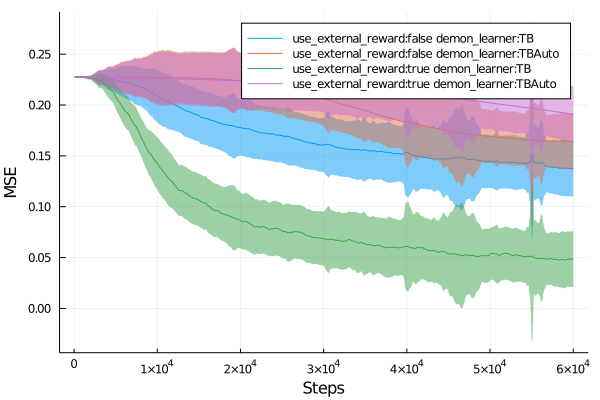

In [144]:
plot_mc_errors(data, labels,step_increment = 50,data_std=data_std)


In [145]:
savefig("./plots/MountainCarMSE.png")

In [165]:
episode_lengths = [load_results(ic,:episode_length, return_type="array") for ic in best_per_algo_ics]


[214, 103, 273, 158, 95, 87, 98, 168, 95, 109, 94, 99, 89, 96, 89, 98, 106, 98, 97, 186, 94, 185, 94, 103, 96, 88, 205, 94, 183, 118, 97, 100, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 328, 1000, 1000, 1000, 340, 1000, 1000, 119, 1000, 895, 237, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 275, 356, 1000, 1000, 365, 1000, 1000, 1000, 1000, 1000, 1000, 861, 1000, 906, 123, 1000, 1000, 1000, 1000, 1000, 522, 237, 201, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 326]
[1000, 1000, 430, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 570]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 10

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1

[1000, 963, 652, 593, 100, 382, 475, 100, 328, 192, 341, 197, 202, 204, 98, 90, 87, 337, 210, 267, 92, 84, 168, 90, 102, 83, 152, 87, 84, 91, 84, 94, 170, 86, 172, 103, 92, 103, 91, 86, 101, 166, 98, 142, 128, 100, 91, 80, 114, 86, 104, 153, 83, 160, 105, 162, 82, 88, 84, 179, 95, 84, 90, 90, 122, 99, 82, 88, 115, 114, 89, 164, 92, 83, 192, 137, 119, 91, 235, 104, 84, 160, 106, 90, 152, 87, 93, 127, 90, 205, 109, 240, 179, 174, 95, 109, 119, 133, 147, 237, 97, 109, 91, 98, 91, 94, 96, 158, 145, 95, 89, 98, 95, 91, 95, 87, 120, 105, 129, 148, 87, 187, 120, 190, 106, 92, 91, 195, 172, 168, 94, 172, 174, 98, 89, 187, 83, 97, 159, 91, 215, 91, 105, 161, 160, 143, 92, 153, 95, 93, 229, 155, 113, 139, 91, 151, 93, 112, 109, 90, 86, 94, 162, 201, 113, 242, 204, 95, 99, 85, 88, 104, 84, 252, 101, 94, 89, 93, 157, 87, 101, 96, 87, 90, 91, 86, 84, 121, 230, 108, 94, 184, 182, 216, 125, 100, 88, 92, 95, 111, 98, 107, 94, 101, 84, 156, 147, 97, 158, 90, 164, 104, 89, 163, 155, 82, 94, 94, 89, 163,

[1000, 1000, 238, 105, 731, 447, 439, 187, 279, 106, 106, 91, 191, 93, 527, 255, 100, 236, 83, 91, 163, 81, 236, 84, 88, 89, 88, 285, 96, 182, 97, 94, 80, 168, 100, 143, 92, 99, 126, 89, 90, 112, 121, 83, 94, 81, 96, 94, 91, 105, 173, 100, 216, 87, 95, 100, 224, 86, 83, 88, 92, 95, 97, 193, 86, 193, 89, 182, 107, 91, 82, 89, 100, 82, 84, 156, 108, 93, 107, 101, 202, 162, 98, 166, 109, 96, 88, 102, 224, 83, 203, 96, 86, 258, 122, 189, 97, 150, 96, 90, 174, 101, 89, 152, 97, 102, 105, 90, 89, 93, 104, 215, 88, 158, 85, 83, 85, 111, 98, 91, 97, 99, 86, 153, 166, 93, 93, 93, 105, 91, 93, 82, 87, 89, 217, 96, 124, 234, 158, 94, 110, 184, 173, 101, 103, 88, 92, 93, 204, 93, 125, 106, 101, 125, 102, 95, 209, 176, 179, 86, 238, 85, 89, 156, 159, 93, 89, 104, 89, 108, 131, 180, 88, 90, 99, 99, 114, 91, 165, 115, 106, 97, 126, 120, 87, 90, 90, 96, 99, 89, 101, 112, 109, 218, 165, 86, 88, 103, 95, 92, 89, 174, 86, 84, 168, 101, 89, 92, 94, 105, 83, 95, 92, 168, 86, 94, 141, 90, 88, 188, 89, 109, 

[497, 1000, 630, 221, 369, 819, 90, 92, 211, 466, 273, 444, 99, 333, 82, 97, 267, 241, 92, 100, 107, 106, 102, 96, 185, 105, 88, 111, 94, 96, 87, 125, 110, 93, 106, 91, 106, 94, 105, 97, 83, 98, 185, 84, 236, 81, 184, 89, 180, 243, 382, 236, 211, 155, 111, 99, 101, 82, 106, 198, 100, 86, 84, 95, 93, 93, 106, 96, 99, 88, 95, 91, 90, 96, 90, 122, 94, 100, 95, 90, 173, 95, 107, 102, 94, 97, 92, 90, 102, 97, 87, 106, 85, 135, 91, 96, 92, 104, 84, 89, 100, 85, 103, 89, 100, 108, 88, 104, 113, 102, 91, 92, 85, 92, 179, 86, 90, 105, 94, 96, 96, 86, 89, 105, 106, 108, 188, 110, 94, 90, 161, 95, 99, 122, 123, 89, 84, 126, 196, 174, 96, 104, 104, 97, 87, 94, 85, 166, 84, 157, 88, 104, 89, 96, 108, 93, 88, 98, 101, 85, 90, 229, 90, 94, 90, 98, 107, 113, 94, 119, 89, 102, 105, 105, 248, 103, 104, 89, 148, 93, 197, 88, 105, 87, 100, 89, 188, 83, 265, 110, 97, 90, 212, 102, 194, 162, 203, 93, 91, 173, 84, 123, 166, 204, 106, 124, 88, 95, 103, 114, 84, 99, 100, 99, 96, 89, 85, 98, 85, 105, 95, 102, 8

[1000, 224, 826, 729, 1000, 291, 483, 337, 90, 174, 169, 93, 93, 93, 387, 242, 100, 92, 99, 172, 160, 88, 212, 165, 93, 106, 96, 99, 221, 220, 104, 105, 86, 84, 94, 88, 92, 214, 158, 172, 161, 189, 90, 84, 83, 88, 94, 91, 86, 85, 155, 105, 97, 86, 158, 126, 171, 165, 164, 116, 206, 116, 94, 154, 101, 86, 186, 102, 100, 93, 89, 85, 95, 93, 220, 95, 91, 85, 104, 184, 90, 107, 91, 86, 199, 93, 87, 103, 90, 90, 107, 94, 184, 94, 84, 92, 92, 108, 102, 85, 91, 90, 186, 195, 122, 205, 84, 104, 92, 89, 93, 159, 94, 129, 88, 99, 86, 94, 108, 101, 91, 211, 86, 90, 90, 223, 171, 109, 194, 87, 91, 95, 90, 105, 101, 97, 84, 88, 87, 100, 86, 89, 90, 92, 87, 101, 89, 90, 98, 91, 156, 101, 107, 159, 95, 110, 87, 158, 91, 145, 123, 105, 88, 93, 98, 95, 94, 88, 91, 86, 90, 90, 146, 88, 88, 83, 91, 85, 92, 87, 113, 103, 89, 85, 91, 88, 84, 201, 88, 94, 111, 89, 94, 90, 101, 91, 99, 108, 86, 109, 86, 81, 103, 177, 94, 114, 92, 107, 94, 82, 106, 86, 201, 97, 86, 87, 101, 94, 87, 91, 106, 105, 152, 87, 92, 

[715, 1000, 683, 204, 99, 113, 624, 181, 105, 96, 457, 93, 97, 102, 324, 268, 93, 87, 290, 349, 135, 178, 82, 182, 83, 105, 101, 81, 81, 189, 90, 170, 95, 99, 178, 99, 90, 89, 165, 168, 96, 104, 100, 214, 201, 92, 138, 189, 99, 94, 82, 128, 94, 194, 204, 95, 146, 85, 97, 105, 93, 180, 84, 157, 101, 191, 95, 106, 148, 156, 179, 92, 104, 96, 84, 102, 109, 83, 116, 104, 91, 82, 102, 125, 166, 86, 175, 103, 107, 110, 87, 89, 106, 88, 160, 87, 189, 97, 158, 86, 160, 105, 106, 100, 105, 84, 162, 187, 99, 108, 98, 90, 84, 88, 105, 128, 100, 105, 115, 108, 83, 85, 91, 182, 180, 105, 189, 107, 99, 93, 162, 89, 106, 101, 183, 108, 107, 88, 93, 102, 104, 199, 97, 220, 101, 98, 99, 94, 92, 89, 93, 100, 91, 98, 157, 93, 99, 86, 90, 103, 84, 156, 88, 88, 187, 97, 94, 92, 89, 86, 93, 101, 93, 93, 111, 93, 165, 122, 188, 215, 89, 193, 96, 97, 95, 90, 120, 103, 89, 122, 91, 88, 87, 100, 90, 105, 89, 90, 100, 108, 89, 156, 88, 102, 85, 92, 105, 108, 94, 89, 197, 165, 105, 301, 192, 85, 90, 168, 91, 201,

[1000, 1000, 230, 942, 266, 347, 98, 583, 302, 97, 176, 100, 88, 395, 266, 99, 97, 93, 91, 93, 236, 92, 90, 246, 88, 106, 88, 92, 100, 85, 108, 87, 96, 102, 85, 94, 98, 88, 83, 92, 156, 102, 100, 83, 104, 108, 100, 86, 85, 106, 164, 117, 92, 104, 86, 81, 255, 84, 215, 121, 84, 84, 100, 172, 97, 100, 104, 87, 93, 192, 169, 100, 110, 108, 102, 168, 193, 97, 96, 126, 87, 95, 89, 86, 102, 107, 160, 100, 163, 87, 178, 86, 99, 160, 98, 97, 129, 103, 141, 83, 82, 96, 100, 103, 97, 100, 86, 135, 223, 92, 161, 92, 103, 104, 86, 91, 85, 106, 93, 102, 84, 194, 85, 83, 109, 93, 91, 86, 89, 124, 173, 90, 94, 160, 102, 97, 165, 97, 122, 108, 99, 100, 92, 105, 85, 114, 100, 88, 86, 91, 106, 89, 119, 88, 103, 94, 85, 109, 93, 94, 100, 105, 94, 135, 86, 99, 92, 88, 117, 96, 111, 157, 120, 97, 105, 96, 124, 94, 109, 228, 225, 97, 128, 380, 92, 96, 90, 186, 195, 175, 354, 412, 104, 90, 343, 94, 202, 99, 87, 159, 91, 89, 89, 87, 83, 160, 154, 155, 107, 86, 92, 87, 91, 158, 106, 96, 265, 169, 165, 91, 89, 

[1000, 1000, 967, 94, 598, 342, 275, 590, 486, 265, 101, 249, 160, 101, 170, 267, 169, 336, 104, 84, 92, 158, 89, 98, 95, 89, 100, 104, 162, 275, 86, 91, 97, 152, 89, 96, 154, 226, 106, 142, 106, 90, 103, 102, 106, 98, 154, 83, 95, 205, 87, 96, 98, 111, 96, 106, 98, 98, 91, 110, 101, 142, 105, 131, 178, 198, 125, 96, 84, 115, 84, 106, 92, 163, 101, 122, 149, 106, 114, 87, 152, 99, 96, 101, 95, 86, 106, 87, 100, 97, 236, 206, 156, 183, 88, 195, 87, 101, 174, 92, 125, 173, 100, 220, 82, 96, 94, 95, 87, 173, 88, 113, 88, 91, 168, 92, 311, 91, 110, 209, 88, 100, 92, 111, 102, 124, 98, 99, 107, 99, 88, 96, 92, 106, 121, 170, 96, 106, 100, 202, 106, 93, 92, 105, 164, 104, 99, 92, 94, 108, 106, 122, 98, 115, 214, 106, 117, 286, 96, 113, 90, 101, 109, 214, 109, 84, 90, 112, 99, 89, 96, 130, 102, 114, 93, 92, 93, 203, 479, 98, 105, 117, 189, 301, 265, 115, 195, 113, 102, 88, 351, 165, 92, 91, 197, 181, 90, 91, 190, 83, 98, 176, 82, 154, 185, 84, 139, 97, 101, 85, 100, 258, 92, 157, 124, 97, 94,

[1000, 903, 481, 673, 99, 426, 191, 102, 109, 102, 282, 101, 182, 499, 89, 94, 103, 84, 93, 101, 99, 93, 167, 324, 163, 85, 85, 263, 117, 85, 95, 87, 93, 88, 90, 101, 166, 83, 91, 117, 172, 89, 100, 89, 87, 82, 156, 97, 87, 251, 88, 88, 99, 102, 108, 96, 107, 98, 86, 89, 86, 96, 101, 169, 105, 88, 87, 99, 84, 100, 83, 85, 88, 97, 89, 253, 98, 93, 95, 90, 234, 171, 90, 92, 86, 87, 93, 229, 92, 206, 99, 92, 169, 166, 214, 153, 169, 97, 178, 88, 92, 157, 193, 108, 151, 84, 155, 200, 128, 105, 86, 83, 86, 150, 144, 88, 92, 97, 183, 100, 130, 93, 103, 100, 83, 89, 150, 85, 106, 190, 151, 170, 96, 85, 158, 96, 98, 88, 91, 116, 88, 104, 184, 109, 151, 95, 86, 168, 99, 194, 203, 170, 95, 151, 96, 159, 97, 175, 95, 83, 90, 96, 91, 85, 95, 173, 84, 175, 92, 88, 88, 97, 93, 166, 91, 175, 199, 90, 109, 93, 97, 92, 96, 183, 98, 87, 91, 92, 99, 193, 98, 103, 102, 102, 96, 89, 124, 127, 86, 120, 84, 87, 117, 96, 167, 92, 94, 150, 85, 83, 142, 196, 143, 101, 89, 89, 95, 92, 184, 145, 206, 96, 94, 91, 

[1000, 627, 989, 511, 461, 263, 94, 582, 98, 104, 308, 94, 89, 424, 87, 94, 90, 93, 204, 107, 271, 89, 98, 156, 278, 89, 81, 106, 89, 157, 87, 104, 99, 98, 88, 90, 94, 93, 274, 93, 159, 104, 91, 247, 89, 170, 100, 166, 99, 99, 187, 190, 100, 94, 182, 102, 87, 87, 86, 87, 91, 101, 96, 92, 101, 169, 90, 178, 130, 103, 83, 105, 166, 162, 92, 199, 94, 91, 168, 100, 97, 179, 163, 166, 169, 90, 84, 165, 163, 88, 92, 90, 92, 90, 94, 90, 94, 88, 90, 94, 107, 155, 158, 159, 85, 98, 103, 104, 107, 90, 91, 96, 98, 83, 193, 169, 147, 104, 87, 86, 87, 191, 84, 113, 90, 97, 84, 179, 106, 113, 183, 87, 141, 101, 157, 98, 99, 104, 95, 97, 178, 84, 162, 160, 105, 174, 91, 92, 190, 100, 112, 115, 157, 87, 192, 153, 104, 120, 86, 175, 85, 91, 89, 89, 89, 103, 102, 209, 96, 90, 161, 102, 88, 86, 249, 99, 176, 98, 104, 99, 181, 89, 97, 173, 98, 96, 104, 98, 87, 90, 98, 92, 96, 225, 164, 97, 87, 91, 99, 99, 96, 98, 99, 112, 93, 174, 165, 96, 104, 101, 90, 187, 89, 88, 104, 91, 108, 98, 167, 97, 102, 239, 21

[1000, 502, 865, 692, 102, 262, 323, 493, 94, 97, 97, 322, 169, 96, 102, 89, 90, 87, 95, 94, 93, 262, 93, 88, 93, 96, 88, 236, 84, 85, 106, 104, 81, 223, 86, 105, 86, 208, 107, 87, 175, 85, 95, 96, 163, 281, 95, 100, 175, 107, 223, 85, 90, 86, 212, 183, 161, 170, 141, 154, 197, 162, 147, 94, 158, 84, 291, 84, 126, 93, 107, 96, 106, 102, 90, 124, 92, 139, 100, 108, 101, 92, 101, 97, 189, 174, 95, 208, 90, 87, 101, 163, 111, 156, 88, 91, 107, 160, 93, 96, 104, 108, 173, 172, 155, 193, 132, 104, 112, 105, 91, 194, 260, 86, 108, 119, 93, 94, 144, 89, 106, 90, 85, 105, 89, 108, 114, 90, 97, 91, 89, 87, 104, 103, 86, 132, 105, 125, 93, 223, 88, 94, 192, 103, 91, 184, 104, 89, 95, 199, 350, 114, 283, 102, 87, 98, 209, 91, 87, 124, 227, 91, 102, 104, 110, 107, 122, 109, 95, 92, 235, 174, 111, 94, 98, 87, 90, 108, 106, 99, 158, 235, 105, 107, 167, 193, 103, 102, 169, 263, 255, 110, 430, 93, 286, 167, 168, 100, 91, 90, 99, 103, 88, 94, 102, 85, 94, 102, 84, 83, 102, 167, 87, 92, 84, 113, 90, 97,

[965, 1000, 936, 341, 256, 569, 341, 291, 191, 97, 102, 202, 96, 95, 413, 168, 99, 90, 280, 86, 172, 159, 91, 93, 86, 89, 89, 85, 183, 96, 90, 97, 83, 98, 84, 204, 188, 83, 154, 108, 87, 87, 95, 83, 91, 123, 107, 88, 89, 101, 115, 103, 89, 223, 86, 175, 103, 96, 105, 93, 161, 83, 110, 84, 86, 88, 207, 100, 164, 103, 97, 165, 93, 98, 102, 92, 168, 95, 96, 85, 88, 89, 100, 187, 98, 305, 112, 106, 96, 95, 89, 107, 111, 95, 155, 173, 104, 171, 90, 212, 88, 90, 177, 91, 161, 172, 89, 93, 96, 160, 100, 189, 87, 99, 86, 94, 95, 93, 99, 97, 144, 96, 104, 216, 229, 97, 89, 94, 87, 88, 96, 99, 179, 156, 161, 89, 99, 86, 89, 84, 89, 92, 89, 84, 111, 108, 94, 86, 102, 88, 152, 88, 91, 132, 124, 99, 97, 84, 103, 102, 102, 86, 90, 108, 97, 166, 99, 87, 219, 100, 105, 91, 89, 121, 108, 98, 100, 88, 105, 103, 187, 105, 168, 106, 155, 88, 93, 86, 85, 87, 141, 88, 98, 96, 105, 86, 117, 94, 96, 88, 182, 101, 92, 104, 87, 191, 259, 126, 146, 180, 161, 163, 193, 91, 187, 258, 91, 105, 83, 92, 199, 270, 200

[1000, 1000, 1000, 371, 173, 575, 91, 251, 101, 93, 100, 90, 87, 89, 99, 102, 164, 90, 378, 98, 90, 88, 109, 83, 159, 102, 94, 165, 91, 97, 194, 217, 108, 83, 108, 176, 101, 149, 92, 197, 158, 84, 91, 99, 176, 86, 95, 242, 84, 101, 91, 98, 149, 159, 88, 99, 88, 93, 93, 177, 81, 196, 164, 98, 93, 147, 93, 90, 200, 161, 100, 79, 87, 83, 90, 90, 103, 171, 101, 84, 222, 197, 106, 104, 93, 167, 93, 91, 224, 85, 100, 85, 172, 196, 166, 162, 174, 167, 203, 83, 82, 83, 86, 97, 84, 82, 102, 82, 97, 93, 87, 83, 161, 91, 88, 94, 166, 82, 126, 86, 90, 98, 98, 83, 94, 100, 82, 87, 107, 88, 234, 94, 87, 89, 82, 82, 91, 103, 94, 188, 187, 96, 107, 95, 112, 83, 96, 203, 96, 162, 105, 99, 175, 173, 96, 204, 90, 94, 121, 115, 101, 95, 88, 98, 100, 102, 98, 92, 127, 88, 84, 87, 89, 99, 129, 172, 112, 116, 93, 83, 179, 91, 130, 116, 122, 89, 87, 157, 192, 102, 85, 100, 90, 98, 120, 96, 157, 110, 196, 109, 109, 103, 93, 192, 237, 201, 108, 208, 89, 90, 88, 195, 92, 226, 86, 87, 87, 183, 86, 87, 89, 105, 89

[530, 1000, 1000, 228, 746, 781, 94, 106, 94, 95, 251, 235, 205, 91, 165, 92, 88, 241, 100, 95, 108, 94, 97, 168, 96, 159, 169, 107, 97, 95, 100, 228, 188, 90, 159, 216, 158, 81, 87, 121, 92, 90, 82, 101, 81, 86, 163, 88, 87, 86, 90, 91, 102, 84, 82, 103, 110, 94, 101, 87, 85, 100, 89, 85, 167, 83, 87, 103, 94, 111, 89, 106, 90, 96, 90, 105, 123, 88, 89, 85, 83, 87, 92, 84, 93, 89, 85, 94, 100, 113, 90, 87, 91, 88, 80, 91, 95, 91, 165, 87, 138, 84, 164, 80, 84, 91, 95, 169, 91, 91, 119, 101, 155, 88, 178, 97, 167, 93, 97, 100, 99, 98, 88, 95, 157, 96, 283, 169, 85, 155, 93, 214, 203, 95, 95, 168, 95, 95, 198, 91, 89, 86, 158, 91, 82, 203, 86, 89, 173, 158, 107, 99, 99, 112, 88, 86, 123, 152, 184, 205, 133, 104, 105, 239, 235, 97, 96, 112, 90, 108, 96, 87, 100, 90, 180, 85, 84, 143, 156, 109, 100, 88, 84, 121, 87, 85, 102, 88, 97, 164, 89, 98, 107, 127, 87, 97, 167, 88, 86, 83, 83, 87, 90, 153, 86, 92, 86, 163, 123, 91, 89, 118, 95, 105, 98, 158, 91, 133, 93, 85, 87, 109, 112, 90, 117, 

[1000, 110, 464, 1000, 482, 92, 106, 198, 102, 801, 339, 98, 460, 93, 247, 249, 192, 240, 161, 87, 88, 100, 83, 174, 93, 96, 88, 298, 89, 100, 101, 195, 108, 166, 83, 87, 87, 83, 127, 92, 81, 130, 99, 80, 85, 92, 94, 100, 84, 101, 90, 105, 84, 107, 158, 95, 85, 204, 91, 102, 124, 99, 84, 81, 99, 92, 115, 84, 104, 95, 87, 84, 100, 82, 102, 104, 110, 86, 87, 106, 86, 140, 102, 101, 99, 85, 88, 99, 86, 101, 95, 84, 82, 170, 106, 184, 100, 238, 407, 274, 178, 256, 101, 97, 97, 98, 85, 95, 92, 134, 96, 87, 202, 193, 91, 103, 84, 92, 83, 188, 105, 94, 99, 106, 81, 86, 89, 105, 101, 105, 144, 102, 84, 161, 188, 99, 114, 87, 272, 247, 96, 98, 196, 102, 87, 94, 104, 89, 105, 184, 87, 95, 96, 299, 108, 88, 89, 115, 91, 89, 186, 85, 87, 135, 89, 97, 107, 92, 97, 89, 158, 115, 111, 102, 89, 201, 193, 91, 103, 207, 98, 93, 162, 103, 86, 167, 91, 86, 86, 101, 84, 92, 89, 95, 105, 86, 116, 185, 159, 95, 84, 88, 199, 167, 90, 136, 102, 158, 202, 149, 110, 108, 237, 84, 93, 108, 86, 200, 92, 93, 93, 12

[1000, 1000, 798, 330, 586, 207, 122, 454, 96, 190, 101, 89, 252, 184, 170, 306, 86, 111, 165, 94, 91, 88, 242, 165, 108, 98, 92, 83, 84, 90, 245, 157, 163, 83, 101, 106, 201, 98, 82, 91, 88, 83, 154, 97, 91, 185, 94, 93, 86, 185, 85, 106, 99, 87, 95, 179, 89, 151, 175, 89, 190, 168, 88, 85, 101, 159, 88, 100, 239, 184, 105, 109, 91, 86, 89, 92, 90, 221, 98, 91, 167, 166, 99, 88, 99, 160, 182, 107, 91, 160, 164, 96, 89, 87, 107, 105, 92, 88, 101, 163, 105, 100, 102, 185, 84, 99, 218, 98, 106, 90, 106, 101, 93, 88, 98, 105, 95, 90, 89, 84, 154, 86, 105, 91, 109, 152, 89, 85, 86, 87, 203, 193, 162, 107, 100, 112, 90, 107, 274, 101, 105, 105, 105, 109, 162, 89, 98, 86, 193, 160, 164, 92, 100, 88, 94, 86, 206, 110, 84, 88, 90, 84, 97, 164, 84, 170, 118, 85, 82, 152, 177, 161, 99, 160, 88, 91, 192, 198, 86, 93, 271, 98, 89, 100, 135, 88, 87, 83, 100, 83, 104, 110, 102, 86, 118, 96, 86, 104, 100, 103, 197, 159, 94, 189, 105, 86, 96, 161, 97, 102, 104, 87, 96, 186, 110, 91, 87, 127, 95, 95, 1

[1000, 600, 1000, 581, 911, 108, 485, 339, 407, 91, 104, 89, 197, 91, 105, 89, 100, 113, 109, 169, 100, 106, 92, 104, 187, 213, 106, 183, 88, 90, 179, 258, 154, 99, 207, 99, 102, 197, 110, 97, 105, 167, 87, 90, 84, 87, 96, 96, 93, 90, 100, 85, 162, 99, 95, 81, 86, 98, 83, 83, 97, 93, 92, 94, 90, 88, 87, 91, 101, 91, 88, 87, 85, 93, 88, 111, 205, 173, 85, 86, 88, 95, 103, 93, 120, 101, 104, 213, 172, 112, 90, 125, 90, 163, 85, 92, 93, 157, 100, 92, 84, 95, 89, 185, 159, 87, 184, 167, 94, 82, 211, 96, 89, 99, 99, 91, 105, 154, 173, 85, 194, 101, 97, 85, 102, 94, 218, 93, 92, 110, 177, 172, 123, 92, 89, 104, 88, 166, 87, 97, 97, 91, 112, 87, 104, 105, 101, 95, 89, 100, 109, 89, 97, 95, 92, 85, 117, 82, 90, 93, 99, 162, 92, 91, 85, 216, 89, 96, 114, 190, 103, 92, 93, 87, 86, 89, 90, 160, 87, 86, 90, 168, 100, 98, 88, 96, 192, 90, 92, 86, 93, 174, 126, 113, 100, 116, 130, 113, 96, 107, 220, 94, 96, 91, 92, 99, 214, 365, 94, 93, 393, 112, 100, 96, 198, 104, 95, 100, 171, 194, 195, 230, 87, 9

[1000, 1000, 949, 190, 268, 649, 97, 441, 262, 212, 95, 102, 164, 96, 86, 104, 101, 94, 100, 86, 91, 100, 86, 89, 92, 94, 168, 254, 97, 82, 96, 87, 101, 85, 201, 87, 178, 188, 86, 161, 87, 98, 172, 96, 84, 103, 96, 88, 96, 84, 92, 93, 188, 83, 82, 182, 95, 94, 93, 95, 87, 86, 83, 88, 160, 86, 154, 91, 97, 88, 124, 84, 95, 155, 111, 92, 94, 86, 95, 177, 100, 168, 184, 91, 88, 93, 108, 87, 194, 95, 85, 86, 91, 89, 95, 99, 88, 101, 100, 88, 88, 189, 86, 90, 168, 104, 173, 87, 91, 97, 84, 88, 86, 158, 99, 111, 88, 101, 89, 88, 168, 158, 86, 95, 85, 166, 87, 93, 93, 182, 105, 99, 95, 108, 104, 105, 153, 204, 98, 90, 90, 103, 102, 91, 86, 216, 94, 106, 128, 96, 107, 100, 106, 222, 198, 252, 253, 208, 181, 91, 101, 92, 213, 103, 112, 94, 94, 221, 100, 102, 239, 87, 87, 256, 98, 185, 96, 158, 89, 170, 114, 108, 101, 104, 186, 101, 126, 110, 213, 197, 101, 85, 85, 185, 183, 98, 219, 100, 89, 90, 89, 186, 94, 116, 87, 111, 91, 204, 92, 103, 158, 105, 100, 187, 186, 100, 90, 95, 207, 86, 102, 92,

[1000, 1000, 106, 769, 273, 92, 354, 93, 102, 99, 401, 102, 373, 179, 90, 471, 102, 218, 85, 91, 93, 100, 173, 88, 204, 186, 92, 93, 90, 85, 235, 105, 211, 89, 189, 93, 86, 83, 99, 86, 92, 101, 81, 83, 205, 98, 84, 83, 84, 82, 86, 104, 98, 82, 183, 81, 91, 162, 94, 82, 99, 182, 90, 141, 82, 83, 100, 165, 89, 108, 122, 165, 85, 92, 101, 80, 89, 183, 98, 85, 87, 81, 111, 87, 83, 122, 85, 99, 87, 107, 204, 96, 97, 106, 179, 201, 85, 194, 329, 91, 108, 262, 95, 106, 196, 96, 121, 86, 100, 87, 89, 87, 163, 110, 172, 87, 95, 156, 87, 93, 99, 91, 87, 106, 104, 99, 99, 192, 88, 145, 113, 98, 98, 86, 149, 105, 260, 100, 86, 95, 99, 191, 173, 102, 161, 182, 95, 96, 100, 91, 91, 99, 89, 90, 174, 159, 94, 159, 88, 105, 91, 106, 102, 89, 86, 98, 89, 121, 95, 89, 97, 153, 89, 96, 104, 85, 142, 89, 90, 114, 128, 92, 161, 107, 84, 99, 149, 225, 84, 92, 132, 179, 103, 105, 105, 87, 108, 227, 687, 108, 96, 176, 121, 166, 202, 102, 101, 338, 98, 154, 94, 98, 85, 91, 192, 101, 88, 117, 86, 101, 107, 164, 

[1000, 625, 614, 769, 90, 489, 111, 98, 250, 103, 88, 102, 89, 174, 348, 96, 97, 625, 99, 220, 103, 95, 262, 175, 103, 98, 199, 89, 167, 107, 163, 317, 92, 84, 192, 94, 167, 83, 94, 97, 210, 83, 86, 90, 88, 82, 88, 84, 154, 93, 167, 117, 93, 184, 117, 88, 119, 185, 99, 80, 132, 201, 318, 90, 369, 97, 106, 89, 241, 206, 100, 88, 90, 84, 90, 192, 86, 88, 183, 165, 87, 92, 163, 84, 234, 164, 168, 92, 209, 181, 158, 91, 95, 121, 84, 171, 90, 93, 117, 100, 195, 103, 93, 90, 129, 212, 105, 92, 102, 98, 94, 90, 88, 92, 89, 107, 90, 101, 124, 90, 88, 104, 123, 218, 89, 93, 120, 107, 108, 110, 176, 100, 90, 203, 89, 104, 105, 102, 87, 96, 92, 105, 112, 312, 86, 84, 101, 94, 106, 84, 89, 177, 85, 165, 95, 88, 105, 84, 104, 94, 108, 92, 160, 105, 92, 108, 103, 92, 161, 97, 162, 90, 96, 93, 89, 97, 127, 107, 90, 107, 100, 230, 110, 174, 91, 92, 91, 92, 94, 93, 185, 165, 160, 94, 91, 93, 107, 95, 94, 162, 241, 97, 166, 89, 101, 104, 89, 172, 288, 97, 103, 89, 88, 92, 86, 89, 89, 89, 222, 168, 93, 9

[1000, 216, 1000, 850, 538, 538, 98, 103, 105, 97, 353, 394, 88, 91, 89, 93, 84, 93, 107, 90, 96, 187, 101, 168, 86, 92, 91, 87, 95, 87, 113, 83, 196, 160, 86, 82, 100, 160, 87, 104, 98, 85, 98, 99, 90, 105, 144, 161, 84, 103, 103, 85, 177, 181, 204, 91, 91, 101, 100, 88, 90, 225, 110, 183, 103, 87, 84, 165, 104, 96, 87, 164, 109, 191, 168, 110, 105, 107, 100, 100, 95, 87, 91, 91, 87, 91, 84, 167, 223, 102, 92, 193, 364, 194, 103, 109, 88, 102, 104, 95, 222, 186, 176, 305, 93, 155, 104, 101, 100, 290, 282, 102, 85, 81, 181, 86, 108, 92, 99, 104, 155, 83, 90, 91, 190, 165, 157, 94, 101, 183, 198, 87, 91, 184, 191, 101, 161, 86, 100, 100, 84, 87, 83, 83, 97, 86, 102, 88, 162, 105, 86, 83, 83, 95, 103, 94, 119, 97, 93, 104, 134, 105, 91, 84, 91, 88, 88, 86, 169, 84, 106, 160, 93, 93, 89, 94, 98, 92, 119, 227, 90, 107, 90, 95, 94, 113, 242, 116, 92, 113, 91, 92, 138, 96, 117, 187, 99, 106, 107, 95, 110, 167, 132, 86, 92, 103, 95, 217, 240, 97, 90, 130, 103, 96, 104, 168, 133, 140, 84, 90, 

[1000, 606, 850, 91, 98, 608, 105, 114, 110, 94, 110, 107, 94, 91, 106, 321, 107, 484, 348, 178, 96, 287, 287, 404, 325, 88, 168, 84, 171, 159, 193, 84, 218, 89, 87, 85, 107, 194, 107, 190, 85, 249, 154, 120, 84, 99, 108, 101, 124, 91, 104, 80, 206, 80, 102, 105, 174, 108, 104, 104, 91, 89, 127, 102, 127, 101, 89, 104, 86, 87, 94, 92, 97, 85, 86, 87, 127, 171, 105, 96, 103, 82, 84, 82, 100, 98, 91, 99, 128, 118, 102, 170, 185, 118, 85, 114, 106, 148, 228, 94, 96, 134, 138, 96, 116, 179, 107, 90, 99, 90, 131, 101, 88, 86, 101, 101, 97, 89, 101, 136, 97, 87, 101, 98, 92, 90, 85, 87, 194, 104, 93, 91, 118, 95, 107, 84, 86, 93, 108, 225, 99, 91, 97, 178, 156, 176, 93, 95, 106, 105, 91, 192, 84, 88, 85, 90, 164, 184, 97, 164, 97, 83, 88, 129, 85, 104, 88, 91, 192, 89, 166, 99, 205, 90, 96, 203, 98, 87, 224, 202, 146, 161, 133, 212, 93, 171, 95, 105, 96, 101, 89, 103, 174, 162, 198, 96, 181, 93, 97, 132, 92, 181, 96, 165, 98, 156, 173, 165, 97, 100, 87, 105, 91, 164, 93, 163, 166, 97, 94, 19

4-element Array{Array{Any,1},1}:
 [[214, 103, 273, 158, 95, 87, 98, 168, 95, 109  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 326], [1000, 1000, 430, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 570], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000  …  1000, 1000, 1000, 1000, 1000, 1000, 1000, 1

In [169]:
function average_first_n(arr_of_arr,n)
    ave = zeros(n)
    for arr in arr_of_arr
        ave += arr[1:n]
    end
    ave /= length(arr_of_arr)
end

average_first_n (generic function with 1 method)

In [174]:
init_episode_lengths = [average_first_n(episode_lengths[i],60) for i in 1:length(episode_lengths)]

4-element Array{Array{Float64,1},1}:
 [957.14, 941.38, 935.16, 922.66, 901.08, 931.08, 935.84, 918.24, 917.02, 914.44  …  1000.0, 997.9, 984.74, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
 [990.76, 984.82, 994.12, 982.92, 978.4, 968.1, 972.92, 964.6, 952.08, 964.32  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
 [935.74, 817.32, 663.18, 395.78, 427.96, 337.34, 274.62, 237.54, 201.96, 195.78  …  121.14, 124.38, 116.42, 119.04, 124.82, 113.92, 122.44, 117.62, 109.36, 120.28]
 [963.06, 819.46, 693.68, 452.74, 389.5, 383.94, 265.62, 312.58, 236.34, 196.24  …  115.82, 115.28, 121.38, 119.7, 118.6, 114.64, 120.02, 120.88, 111.52, 125.14]

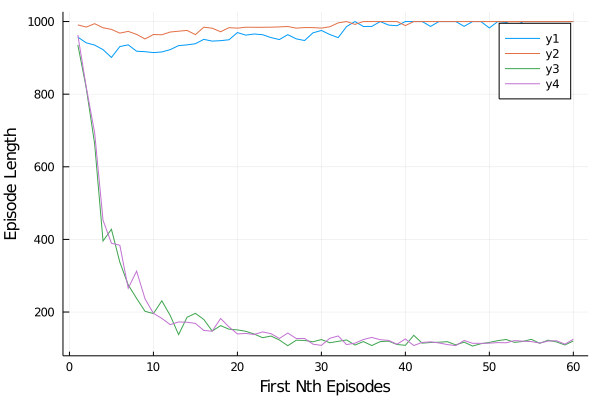

In [235]:
p = plot()
plot!(p,init_episode_lengths,ylabel="Episode Length",xlabel="First Nth Episodes")

In [229]:
labels

4-element Array{String,1}:
 " use_external_reward:false demon_learner:TB"
 " use_external_reward:false demon_learner:TBAuto"
 " use_external_reward:true demon_learner:TB"
 " use_external_reward:true demon_learner:TBAuto"

In [175]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, "end", ylim=(0.0, 0.4))

LoadError: [91mUndefVarError: plot_gvfn_stepsize_sense not defined[39m

In [176]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn/data: No such file or directory[39m

In [177]:
0.01*1.5.^(-18:2:1)

10-element Array{Float64,1}:
 6.766394845988643e-6
 1.5224388403474448e-5
 3.425487390781751e-5
 7.707346629258939e-5
 0.00017341529915832613
 0.0003901844231062338
 0.0008779149519890261
 0.0019753086419753087
 0.0044444444444444444
 0.01

In [178]:
diff(ic_rnn_adam)["alpha"]

LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [179]:
plot_rnn_stepsize_sens(ic_rnn, 35, "end"; ylims=(0.0,0.3))

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [180]:
plot_rnn_stepsize_sens(ic_rnn, 40, "end"; ylims=(0.0,0.3), legend=false)

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [181]:
plot_rnn_stepsize_sens(ic_rnn, 110, "end"; ylims=(0.0,0.3))

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [182]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_adam/data: No such file or directory[39m

In [183]:
plot_rnn_stepsize_sens(ic_rnn_adam, 35, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [184]:
plot_rnn_stepsize_sens(ic_rnn_adam, 40, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [185]:
plot_rnn_stepsize_sens(ic_rnn_adam, 110, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [186]:
plot_rnn_stepsize_sens(ic_rnn_adam, 5, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

## RNN Aux Tasks

In [187]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
diff(ic_rnn_at)

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task/data: No such file or directory[39m

In [188]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "end"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [189]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "all"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [190]:
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));
diff(ic_rnn_at_adam)

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task_adam/data: No such file or directory[39m

In [191]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "end"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [192]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "all"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

# Final Params

In [193]:
function get_final_gvfn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    @showprogress for horde ∈ diff(sub_ic)["gvfn-horde"]
        sub_sub_ic = search(sub_ic, Dict("gvfn-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, _ = get_best_func(sub_sub_sub_ic)
            push!(arg_list, Dict("gvfn-horde"=>horde, "truncation"=>τ, "alpha"=>prm))
        end

    end
    arg_list
end

function get_final_rnn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for cell ∈ diff(sub_ic)["cell"]
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end

function get_final_rnn_at_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for (horde, cell) ∈ Iterators.product(diff(sub_ic)["at-horde"], diff(sub_ic)["cell"])
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell, "at-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "at-horde"=>horde, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end


get_final_rnn_at_params (generic function with 1 method)

## GVFN

In [194]:
ic_gvfn = ItemCollection(joinpath(data_home, "compassworld_gvfn/data"));
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_gvfn_rmsprop/data"));
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_gvfn/data: No such file or directory[39m

In [195]:
diff(ic_gvfn)
ic_gvfn.items[1].parsed_args

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [196]:
args_list = get_final_gvfn_params(ic_gvfn, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_descent.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [197]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_rmsprop not defined[39m

In [198]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_adam.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_adam not defined[39m

In [199]:
args_list = get_final_gvfn_params(ic_gvfn, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_descent_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [200]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_rmsprop not defined[39m

In [201]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_adam_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_adam not defined[39m

## RNN

In [202]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));
ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn/data: No such file or directory[39m

In [203]:
diff(ic_rnn)

LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [204]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_40.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [205]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [206]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_5.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [207]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [208]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_40_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [209]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [210]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_5_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [211]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

### AT RNNs

In [212]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
# ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task/data: No such file or directory[39m

In [213]:
args_list = get_final_rnn_at_params(ic_rnn_at, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task.jld2" args_list

LoadError: [91mUndefVarError: ic_rnn_at not defined[39m

In [214]:
args_list = get_final_rnn_at_params(ic_rnn_at_adam, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task_adam.jld2" args_list

LoadError: [91mUndefVarError: ic_rnn_at_adam not defined[39m

# Forecast Networks

In [215]:
ic_forecast = ItemCollection(joinpath(data_home, "compassworld_forecast/data"));
ic_forecast_rmsprop = ItemCollection(joinpath(data_home, "compassworld_forecast_rmsprop/data"));
ic_forecast_adam = ItemCollection(joinpath(data_home, "compassworld_forecast_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_forecast/data: No such file or directory[39m

In [216]:
diff(ic_forecast_adam)

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m

In [217]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast not defined[39m

In [218]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_rmsprop not defined[39m

In [219]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m

In [220]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast not defined[39m

In [221]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_rmsprop not defined[39m

In [222]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m